In [1]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from collections import Counter
from matplotlib import colors as mcolors
from tabulate import tabulate

In [2]:
df = pd.read_csv("online_retail_II.csv")
df.shape

(1067371, 8)

In [3]:
df.nunique()

Invoice        53628
StockCode       5305
Description     5698
Quantity        1057
InvoiceDate    47635
Price           2807
Customer ID     5942
Country           43
dtype: int64

In [4]:
df.describe()
df.dtypes

Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object

In [5]:
 #check for null values
df.isnull().sum().any()

True

In [6]:
pd.DataFrame(df.isnull().sum(), columns = ["Number of missing values"])

Number of missing values
Invoice                             0
StockCode                           0
Description                      4382
Quantity                            0
InvoiceDate                         0
Price                               0
Customer ID                    243007
Country                             0

# dealing with missing Customer ID 

In [7]:
#df.dropna(subset = ['Description'], inplace=True)
#df['Customer ID'] = df['Customer ID'].interpolate(method = 'linear', limit_direction ='forward',axi=0)
df.dropna(subset = ['Customer ID'], inplace=True)
pd.DataFrame(df.isnull().sum(), columns = ["Number of missing values"])

Number of missing values
Invoice                             0
StockCode                           0
Description                         0
Quantity                            0
InvoiceDate                         0
Price                               0
Customer ID                         0
Country                             0

In [8]:
#Now, we will try converting the data again to numeric datatype and it should work fine.
df['Customer ID']= df['Customer ID'].astype(int)
df['Customer ID']= df['Customer ID'].astype(str)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# We will just check the datatype as well
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID            object
Country                object
dtype: object

In [9]:
ggg = df[df.duplicated()]
df = df.drop_duplicates(keep='first')
df.shape

(797885, 8)

In [10]:
df.head() 

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price Customer ID         Country  
0 2009-12-01 07:45:00   6.95       13085  United Kingdom  
1 2009-12-01 07:45:00   6.75       13085  United Kingdom  
2 2009-12-01 07:45:00   6.75       13085  United Kingdom  
3 2009-12-01 07:45:00   2.10       13085  United Kingdom  
4 2009-12-01 07:45:00   1.25       13085  United Kingdom

# Menaging Cancelled Transactions

In [11]:
# Filter out the rows with InvoiceNo starting with "C" and create a new column indicating the transaction status
df['Transaction_Status'] = np.where(df['Invoice'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')
df.head()
# Analyze the characteristics of these rows (considering the new column)
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.drop('Customer ID', axis=1)

Invoice StockCode                       Description  Quantity  \
178      C489449     22087          PAPER BUNTING WHITE LACE       -12   
179      C489449    85206A      CREAM FELT EASTER EGG BASKET        -6   
180      C489449     21895     POTTING SHED SOW 'N' GROW SET        -4   
181      C489449     21896                POTTING SHED TWINE        -6   
182      C489449     22083        PAPER CHAIN KIT RETRO SPOT       -12   
...          ...       ...                               ...       ...   
1065910  C581490     23144   ZINC T-LIGHT HOLDER STARS SMALL       -11   
1067002  C581499         M                            Manual        -1   
1067176  C581568     21258        VICTORIAN SEWING BOX LARGE        -5   
1067177  C581569     84978  HANGING HEART JAR T-LIGHT HOLDER        -1   
1067178  C581569     20979     36 PENCILS TUBE RED RETROSPOT        -5   

                InvoiceDate   Price         Country Transaction_Status  
178     2009-12-01 10:33:00    2.95       Australia          Cancelled  
179     2009-12-01 10:33:00    1.65       Australia          Cancelled  
180     2009-12-01 10:33:00    4.25       Australia          Cancelled  
181     2009-12-01 10:33:00    2.10       Australia          Cancelled  
182     2009-12-01 10:33:00    2.95       Australia          Cancelled  
...                     ...     ...             ...                ...  
1065910 2011-12-09 09:57:00    0.83  United Kingdom          Cancelled  
1067002 2011-12-09 10:28:00  224.69  United Kingdom          Cancelled  
1067176 2011-12-09 11:57:00   10.95  United Kingdom          Cancelled  
1067177 2011-12-09 11:58:00    1.25  United Kingdom          Cancelled  
1067178 2011-12-09 11:58:00    1.25  United Kingdom          Cancelled  

[18390 rows x 8 columns]

In [12]:
# Finding the percentage of cancelled transactions
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100

# Printing the percentage of cancelled transactions
print(f"The percentage of cancelled transactions in the dataset is: {cancelled_percentage:.2f}%")

The percentage of cancelled transactions in the dataset is: 2.30%


# Adding New Column of the actual ammount payed for products

In [13]:
#Add new column whic calculates the actual funds required
df['Revenue'] = df['Quantity']*df['Price']
df.head(20)

Invoice StockCode                          Description  Quantity  \
0   489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1   489434    79323P                   PINK CHERRY LIGHTS        12   
2   489434    79323W                  WHITE CHERRY LIGHTS        12   
3   489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4   489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
5   489434     22064           PINK DOUGHNUT TRINKET POT         24   
6   489434     21871                  SAVE THE PLANET MUG        24   
7   489434     21523   FANCY FONT HOME SWEET HOME DOORMAT        10   
8   489435     22350                            CAT BOWL         12   
9   489435     22349       DOG BOWL , CHASING BALL DESIGN        12   
10  489435     22195         HEART MEASURING SPOONS LARGE        24   
11  489435     22353   LUNCHBOX WITH CUTLERY FAIRY CAKES         12   
12  489436    48173C                DOOR MAT BLACK FLOCK         10   
13  489436     21755             LOVE BUILDING BLOCK WORD        18   
14  489436     21754             HOME BUILDING BLOCK WORD         3   
15  489436     84879        ASSORTED COLOUR BIRD ORNAMENT        16   
16  489436     22119           PEACE WOODEN BLOCK LETTERS         3   
17  489436     22142         CHRISTMAS CRAFT WHITE FAIRY         12   
18  489436     22296            HEART IVORY TRELLIS LARGE        12   
19  489436     22295            HEART FILIGREE DOVE LARGE        12   

           InvoiceDate  Price Customer ID         Country Transaction_Status  \
0  2009-12-01 07:45:00   6.95       13085  United Kingdom          Completed   
1  2009-12-01 07:45:00   6.75       13085  United Kingdom          Completed   
2  2009-12-01 07:45:00   6.75       13085  United Kingdom          Completed   
3  2009-12-01 07:45:00   2.10       13085  United Kingdom          Completed   
4  2009-12-01 07:45:00   1.25       13085  United Kingdom          Completed   
5  2009-12-01 07:45:00   1.65       13085  United Kingdom          Completed   
6  2009-12-01 07:45:00   1.25       13085  United Kingdom          Completed   
7  2009-12-01 07:45:00   5.95       13085  United Kingdom          Completed   
8  2009-12-01 07:46:00   2.55       13085  United Kingdom          Completed   
9  2009-12-01 07:46:00   3.75       13085  United Kingdom          Completed   
10 2009-12-01 07:46:00   1.65       13085  United Kingdom          Completed   
11 2009-12-01 07:46:00   2.55       13085  United Kingdom          Completed   
12 2009-12-01 09:06:00   5.95       13078  United Kingdom          Completed   
13 2009-12-01 09:06:00   5.45       13078  United Kingdom          Completed   
14 2009-12-01 09:06:00   5.95       13078  United Kingdom          Completed   
15 2009-12-01 09:06:00   1.69       13078  United Kingdom          Completed   
16 2009-12-01 09:06:00   6.95       13078  United Kingdom          Completed   
17 2009-12-01 09:06:00   1.45       13078  United Kingdom          Completed   
18 2009-12-01 09:06:00   1.65       13078  United Kingdom          Completed   
19 2009-12-01 09:06:00   1.65       13078  United Kingdom          Completed   

    Revenue  
0     83.40  
1     81.00  
2     81.00  
3    100.80  
4     30.00  
5     39.60  
6     30.00  
7     59.50  
8     30.60  
9     45.00  
10    39.60  
11    30.60  
12    59.50  
13    98.10  
14    17.85  
15    27.04  
16    20.85  
17    17.40  
18    19.80  
19    19.80

In [14]:
df['Revenue']

0           83.40
1           81.00
2           81.00
3          100.80
4           30.00
            ...  
1067366     12.60
1067367     16.60
1067368     16.60
1067369     14.85
1067370     18.00
Name: Revenue, Length: 797885, dtype: float64

# Correcting StockCode Anomalies

In [15]:
# Finding the number of unique stock codes
unique_stock_codes = df['StockCode'].nunique()
unique_stock_codes

4646

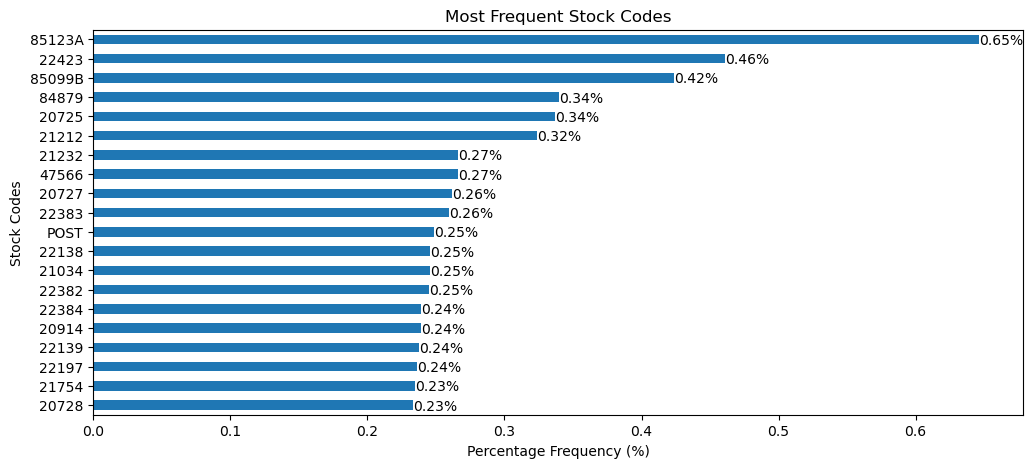

In [16]:
import matplotlib.pyplot as plt
# Finding the  most frequent stock codes
top_stock_codes = df['StockCode'].value_counts(normalize=True).head(20) * 100

# Plotting the top 10 most frequent stock codes
plt.figure(figsize=(12, 5))
top_stock_codes.plot(kind='barh')

# Adding the percentage frequency on the bars
for index, value in enumerate(top_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

In [17]:
# Finding the number of numeric characters in each unique stock code
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

# Printing the value counts for unique stock codes

print(numeric_char_counts_in_unique_codes)

5    4633
0       8
1       2
3       2
4       1
dtype: int64


In [18]:
# Finding and printing the stock codes with 0 and 1 numeric characters
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

anomalous_stock_codes

['POST',
 'D',
 'M',
 'C2',
 'BANK CHARGES',
 'PADS',
 'ADJUST',
 'ADJUST2',
 'DOT',
 'CRUK']

In [19]:
# Removing rows with anomalous stock codes from the dataset
# Removing rows with anomalous stock codes from the dataset
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

In [20]:
df.shape[0]

794241

# Cleaning Description Column

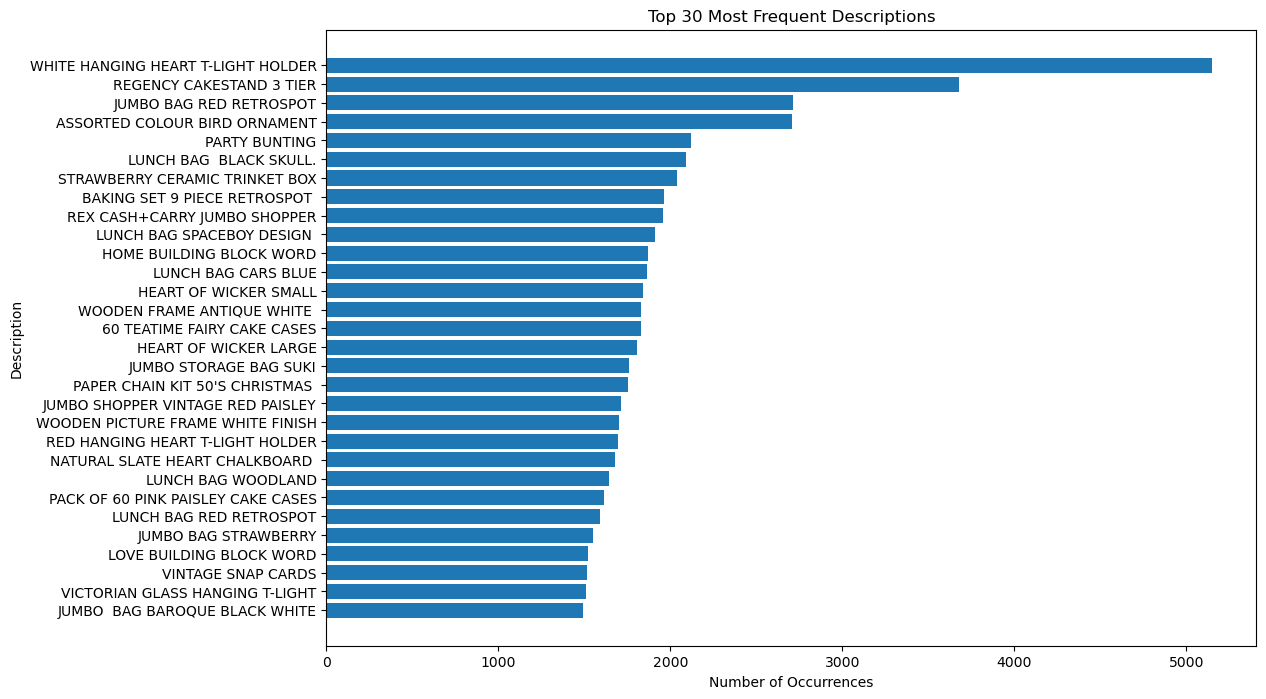

In [21]:
# Calculate the occurrence of each unique description and sort them
description_counts = df['Description'].value_counts()

# Get the top 30 descriptions
top_30_descriptions = description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1])

# Adding labels and title
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Show the plot
plt.show()

In [22]:
# Find unique descriptions containing lowercase characters
lowercase_descriptions = df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# Print the unique descriptions containing lowercase characters
print("The unique descriptions containing lowercase characters are:")
print("-"*60)
for desc in lowercase_descriptions:
    print(desc)

The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 40x40cm
POLYESTER FILLER PAD 60x40cm
POLYESTER FILLER PAD 65CMx65CM
POLYESTER FILLER PAD 45x45cm
BAG 125g SWIRLY MARBLES
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
FOLK ART GREETING CARD,pack/12
BAG 250g SWIRLY MARBLES
POLYESTER FILLER PAD 30CMx30CM
This is a test product.
POLYESTER FILLER PAD 45x30cm
 SET Of 6 SOLDIER SKITTLES
THE KING GIFT BAG 25x24x12cm
FRENCH BLUE METAL DOOR SIGN, No
NUMBER TILE COTTAGE GARDEN, No
NUMBER TILE VINTAGE FONT, No 
NUMBER TILE VINTAGE FONT No 
FRENCH BLUE METAL DOOR SIGN No
NUMBER TILE COTTAGE GARDEN No
3 TRADITIONAl BISCUIT CUTTERS  SET
FLOWERS HANDBAG blue and orange
Next Day Carriage
High Resolution Image


In [23]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

# Remove rows with service-related information in the description
df = df[~df['Description'].isin(service_related_descriptions)]

# Standardize the text to uppercase to maintain uniformity across the dataset
df['Description'] = df['Description'].str.upper()

In [24]:
# Getting the number of rows in the dataframe
df.shape[0]

794158

# Treating prices with 0 or less

In [25]:
# Removing records with a unit price of zero to avoid potential data entry errors
df = df[(df['Price'] > 0)]
# Resetting the index of the cleaned dataset
df.reset_index(drop=True, inplace=True)
df.shape

(794096, 10)

# Actual Price Payed by a Particular Customer

In [26]:
#group by invoice and stockcode
crm_by_provCatg=df.groupby(['Customer ID'])['Quantity','Revenue']
total_price = crm_by_provCatg.sum().reset_index().sort_values(by=['Customer ID'])
total_price

C:\Users\Simphiwe\AppData\Local\Temp\ipykernel_3304\3458362061.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  crm_by_provCatg=df.groupby(['Customer ID'])['Quantity','Revenue']


Customer ID  Quantity  Revenue
0          12346        69   368.36
1          12347      2967  4921.53
2          12348      2704  1658.40
3          12349      1616  3654.54
4          12350       196   294.40
...          ...       ...      ...
5870       18283      1677  2658.95
5871       18284       493   411.68
5872       18285       144   377.00
5873       18286       591  1138.43
5874       18287      3010  4127.89

[5875 rows x 3 columns]

# Generating new Features

# recency

In [27]:
# Convert InvoiceDate to datetime and extract only the date
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Find the most recent purchase date for each customer
customer_data = df.groupby('Customer ID')['InvoiceDay'].max().reset_index()

# Find the most recent date in the entire dataset
most_recent_date = df['InvoiceDay'].max()


# Convert InvoiceDay to datetime type before subtraction
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the number of days since the last purchase for each customer
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Remove the InvoiceDay column
customer_data.drop(columns=['InvoiceDay'], inplace=True)

customer_data.head()

Customer ID  Days_Since_Last_Purchase
0       12346                       325
1       12347                         2
2       12348                        75
3       12349                        18
4       12350                       310

## frequency

In [28]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('Customer ID')['Invoice'].nunique().reset_index()
total_transactions.rename(columns={'Invoice': 'Total_Transactions'}, inplace=True)

# Calculate the total number of products purchased by each customer
total_products_purchased = df.groupby('Customer ID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_transactions, on='Customer ID')
customer_data = pd.merge(customer_data, total_products_purchased, on='Customer ID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

Customer ID  Days_Since_Last_Purchase  Total_Transactions  \
0       12346                       325                  14   
1       12347                         2                   8   
2       12348                        75                   5   
3       12349                        18                   4   
4       12350                       310                   1   

   Total_Products_Purchased  
0                        69  
1                      2967  
2                      2704  
3                      1616  
4                       196

## monetary

In [29]:
# Calculate the total spend by each customer
total_spend = df.groupby('Customer ID')['Revenue'].sum().reset_index()

# Calculate the average transaction value for each customer
average_transaction_value = total_spend.merge(total_transactions, on='Customer ID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Revenue'] / average_transaction_value['Total_Transactions']

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, total_spend, on='Customer ID')
customer_data = pd.merge(customer_data, average_transaction_value[['Customer ID', 'Average_Transaction_Value']], on='Customer ID')

# Display the first few rows of the customer_data dataframe 
customer_data.head()

Customer ID  Days_Since_Last_Purchase  Total_Transactions  \
0       12346                       325                  14   
1       12347                         2                   8   
2       12348                        75                   5   
3       12349                        18                   4   
4       12350                       310                   1   

   Total_Products_Purchased  Revenue  Average_Transaction_Value  
0                        69   368.36                  26.311429  
1                      2967  4921.53                 615.191250  
2                      2704  1658.40                 331.680000  
3                      1616  3654.54                 913.635000  
4                       196   294.40                 294.400000

## Diversity of products

In [30]:
# Calculate the number of unique products purchased by each customer
unique_products_purchased = df.groupby('Customer ID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Merge the new feature into the customer_data dataframe
customer_data = pd.merge(customer_data, unique_products_purchased, on='Customer ID') 

# Display the first few rows of the customer_data dataframe
customer_data.head()

Customer ID  Days_Since_Last_Purchase  Total_Transactions  \
0       12346                       325                  14   
1       12347                         2                   8   
2       12348                        75                   5   
3       12349                        18                   4   
4       12350                       310                   1   

   Total_Products_Purchased  Revenue  Average_Transaction_Value  \
0                        69   368.36                  26.311429   
1                      2967  4921.53                 615.191250   
2                      2704  1658.40                 331.680000   
3                      1616  3654.54                 913.635000   
4                       196   294.40                 294.400000   

   Unique_Products_Purchased  
0                         27  
1                        126  
2                         24  
3                        138  
4                         16

## customer Behavoural Features

In [31]:
# Extract day of week and hour from InvoiceDate
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour
df['Month'] = df['InvoiceDate'].dt.month

# Calculate the average number of days between consecutive purchases
days_between_purchases = df.groupby('Customer ID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('Customer ID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)


# Find the favorite shopping day of the week
favorite_shopping_day = df.groupby(['Customer ID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('Customer ID')['Count'].idxmax()][['Customer ID', 'Day_Of_Week']]

# Find the favorite shopping hour of the day
favorite_shopping_hour = df.groupby(['Customer ID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('Customer ID')['Count'].idxmax()][['Customer ID', 'Hour']]

# Find the year which transaction was made
frequent_month = df.groupby(['Customer ID', 'Month']).size().reset_index(name='Count')
frequent_month = frequent_month.loc[frequent_month.groupby('Customer ID')['Count'].idxmax()][['Customer ID', 'Month']]


# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, average_days_between_purchases, on='Customer ID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='Customer ID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='Customer ID')
customer_data = pd.merge(customer_data, frequent_month , on='Customer ID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

Customer ID  Days_Since_Last_Purchase  Total_Transactions  \
0       12346                       325                  14   
1       12347                         2                   8   
2       12348                        75                   5   
3       12349                        18                   4   
4       12350                       310                   1   

   Total_Products_Purchased  Revenue  Average_Transaction_Value  \
0                        69   368.36                  26.311429   
1                      2967  4921.53                 615.191250   
2                      2704  1658.40                 331.680000   
3                      1616  3654.54                 913.635000   
4                       196   294.40                 294.400000   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                         27                       11.428571            0   
1                        126                        1.819005            1   
2                         24                        8.066667            0   
3                        138                        4.073864            3   
4                         16                        0.000000            2   

   Hour  Month  
0    13      6  
1    14     10  
2    14      9  
3     9     11  
4    16      2

## geographic feafures

In [32]:
df['Country'].value_counts(normalize=True).head()

United Kingdom    0.899892
Germany           0.020971
EIRE              0.019854
France            0.016868
Netherlands       0.006317
Name: Country, dtype: float64

In [33]:
# Group by CustomerID and Country to get the number of transactions per country for each customer
customer_country = df.groupby(['Customer ID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Get the country with the maximum number of transactions for each customer (in case a customer has transactions from multiple countries)
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('Customer ID')
customer_main_country.head(50)

Customer ID         Country  Number_of_Transactions
5443       17841  United Kingdom                   12623
2540       14911            EIRE                   11252
405        12748  United Kingdom                    6625
2240       14606  United Kingdom                    6486
1736       14096  United Kingdom                    5095
2938       15311  United Kingdom                    4576
1795       14156            EIRE                    4066
2280       14646     Netherlands                    3848
743        13089  United Kingdom                    3390
4164       16549  United Kingdom                    3098
1936       14298  United Kingdom                    2868
2667       15039  United Kingdom                    2713
2161       14527  United Kingdom                    2705
5451       17850  United Kingdom                    2526
2633       15005  United Kingdom                    2478
735        13081  United Kingdom                    2351
5115       17511  United Kingdom                    2075
914        13263  United Kingdom                    1900
1798       14159  United Kingdom                    1844
3343       15719  United Kingdom                    1781
4985       17377  United Kingdom                    1730
4395       16782  United Kingdom                    1699
5521       17920  United Kingdom                    1642
3179       15555  United Kingdom                    1637
2139       14505  United Kingdom                    1591
576        12921  United Kingdom                    1577
1336       13694  United Kingdom                    1545
2429       14796  United Kingdom                    1520
2314       14680  United Kingdom                    1438
5717       18118  United Kingdom                    1435
3618       15998  United Kingdom                    1435
2403       14769  United Kingdom                    1407
340        12681          France                    1406
790        13137  United Kingdom                    1394
3653       16033  United Kingdom                    1376
3171       15547  United Kingdom                    1331
5191       17589  United Kingdom                    1309
4946       17338  United Kingdom                    1308
4326       16713  United Kingdom                    1281
2301       14667  United Kingdom                    1280
2049       14415  United Kingdom                    1274
5359       17757  United Kingdom                    1261
883        13230  United Kingdom                    1251
133        12471         Germany                    1244
1208       13564  United Kingdom                    1237
4839       17231  United Kingdom                    1216
3391       15768  United Kingdom                    1210
5413       17811  United Kingdom                    1173
3778       16161  United Kingdom                    1173
5277       17675  United Kingdom                    1149

In [34]:
customer_country.groupby(['Country'])['Customer ID'].aggregate('count').reset_index().sort_values('Customer ID', ascending=False)

Country  Customer ID
38        United Kingdom         5357
14               Germany          107
13                France           93
32                 Spain           38
3                Belgium           29
28              Portugal           23
24           Netherlands           22
34           Switzerland           22
33                Sweden           19
18                 Italy           17
0              Australia           15
12               Finland           13
1                Austria           13
6        Channel Islands           13
9                Denmark           12
26                Norway           12
7                 Cyprus           11
19                 Japan           10
36                   USA            8
27                Poland            6
39           Unspecified            6
15                Greece            5
5                 Canada            5
17                Israel            4
37  United Arab Emirates            4
10                  EIRE            3
29                   RSA            2
20                 Korea            2
23                 Malta            2
4                 Brazil            2
2                Bahrain            2
25               Nigeria            1
30          Saudi Arabia            1
31             Singapore            1
22             Lithuania            1
21               Lebanon            1
16               Iceland            1
35              Thailand            1
11    European Community            1
8         Czech Republic            1
40           West Indies            1

# Cancellation Insights

In [35]:
# Calculate the total number of transactions made by each customer
total_transactions = df.groupby('Customer ID')['Invoice'].nunique().reset_index()

# Calculate the number of cancelled transactions for each customer
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('Customer ID')['Invoice'].nunique().reset_index()
cancellation_frequency.rename(columns={'Invoice': 'Cancellation_Frequency'}, inplace=True)

# Merge the Cancellation Frequency data into the customer_data dataframe
customer_data = pd.merge(customer_data, cancellation_frequency, on='Customer ID', how='left')

# Replace NaN values with 0 (for customers who have not cancelled any transaction)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

# Calculate the Cancellation Rate
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['Invoice']

# Display the first few rows of the customer_data dataframe
customer_data.head()

Customer ID  Days_Since_Last_Purchase  Total_Transactions  \
0       12346                       325                  14   
1       12347                         2                   8   
2       12348                        75                   5   
3       12349                        18                   4   
4       12350                       310                   1   

   Total_Products_Purchased  Revenue  Average_Transaction_Value  \
0                        69   368.36                  26.311429   
1                      2967  4921.53                 615.191250   
2                      2704  1658.40                 331.680000   
3                      1616  3654.54                 913.635000   
4                       196   294.40                 294.400000   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                         27                       11.428571            0   
1                        126                        1.819005            1   
2                         24                        8.066667            0   
3                        138                        4.073864            3   
4                         16                        0.000000            2   

   Hour  Month  Cancellation_Frequency  Cancellation_Rate  
0    13      6                     2.0           0.142857  
1    14     10                     0.0           0.000000  
2    14      9                     0.0           0.000000  
3     9     11                     1.0           0.250000  
4    16      2                     0.0           0.000000

In [36]:
# Extract month and year from InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
#df['Month'] = df['InvoiceDate'].dt.month

# Calculate monthly spending for each customer
monthly_spending = df.groupby(['Customer ID', 'Year', 'Month'])['Revenue'].sum().reset_index()

# Calculate Seasonal Buying Patterns: We are using monthly frequency as a proxy for seasonal buying patterns
seasonal_buying_patterns = monthly_spending.groupby('Customer ID')['Revenue'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Replace NaN values in Monthly_Spending_Std with 0, implying no variability for customers with single transaction month
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# Calculate Trends in Spending 
# We are using the slope of the linear trend line fitted to the customer's spending over time as an indicator of spending trends
def calculate_trend(spend_data):
    # If there are more than one data points, we calculate the trend using linear regression
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # If there is only one data point, no trend can be calculated, hence we return 0
    else:
        return 0

# Apply the calculate_trend function to find the spending trend for  each customer
spending_trends = monthly_spending.groupby('Customer ID')['Revenue'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Revenue': 'Spending_Trend'}, inplace=True)

# Merge the new features into the customer_data dataframe
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='Customer ID')
customer_data = pd.merge(customer_data, spending_trends, on='Customer ID')

# Display the first few rows of the customer_data dataframe
customer_data.head()

Customer ID  Days_Since_Last_Purchase  Total_Transactions  \
0       12346                       325                  14   
1       12347                         2                   8   
2       12348                        75                   5   
3       12349                        18                   4   
4       12350                       310                   1   

   Total_Products_Purchased  Revenue  Average_Transaction_Value  \
0                        69   368.36                  26.311429   
1                      2967  4921.53                 615.191250   
2                      2704  1658.40                 331.680000   
3                      1616  3654.54                 913.635000   
4                       196   294.40                 294.400000   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                         27                       11.428571            0   
1                        126                        1.819005            1   
2                         24                        8.066667            0   
3                        138                        4.073864            3   
4                         16                        0.000000            2   

   Hour  Month  Cancellation_Frequency  Cancellation_Rate  \
0    13      6                     2.0           0.142857   
1    14     10                     0.0           0.000000   
2    14      9                     0.0           0.000000   
3     9     11                     1.0           0.250000   
4    16      2                     0.0           0.000000   

   Monthly_Spending_Mean  Monthly_Spending_Std  Spending_Trend  
0              61.393333             62.243860      -21.021143  
1             615.191250            315.773658        3.339405  
2             331.680000            187.058966      -22.812000  
3             913.635000            647.144349      452.920000  
4             294.400000              0.000000        0.000000

In [37]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5767 entries, 0 to 5766
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Customer ID                     5767 non-null   object 
 1   Days_Since_Last_Purchase        5767 non-null   int64  
 2   Total_Transactions              5767 non-null   int64  
 3   Total_Products_Purchased        5767 non-null   int64  
 4   Revenue                         5767 non-null   float64
 5   Average_Transaction_Value       5767 non-null   float64
 6   Unique_Products_Purchased       5767 non-null   int64  
 7   Average_Days_Between_Purchases  5767 non-null   float64
 8   Day_Of_Week                     5767 non-null   int64  
 9   Hour                            5767 non-null   int64  
 10  Month                           5767 non-null   int64  
 11  Cancellation_Frequency          5767 non-null   float64
 12  Cancellation_Rate               57

In [38]:
# Changing the data type of 'CustomerID' to string as it is a unique identifier and not used in mathematical operations
customer_data['Customer ID'] = customer_data['Customer ID'].astype(str)

# Convert data types of columns to optimal types
customer_data = customer_data.convert_dtypes()
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5767 entries, 0 to 5766
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Customer ID                     5767 non-null   string 
 1   Days_Since_Last_Purchase        5767 non-null   Int64  
 2   Total_Transactions              5767 non-null   Int64  
 3   Total_Products_Purchased        5767 non-null   Int64  
 4   Revenue                         5767 non-null   Float64
 5   Average_Transaction_Value       5767 non-null   Float64
 6   Unique_Products_Purchased       5767 non-null   Int64  
 7   Average_Days_Between_Purchases  5767 non-null   Float64
 8   Day_Of_Week                     5767 non-null   Int64  
 9   Hour                            5767 non-null   Int64  
 10  Month                           5767 non-null   Int64  
 11  Cancellation_Frequency          5767 non-null   Int64  
 12  Cancellation_Rate               57

# Outlier Detection

In [39]:
# Initializing the IsolationForest model with a contamination parameter of 0.05
model = IsolationForest(contamination=0.05, random_state=0)

# Fitting the model on our dataset (converting DataFrame to NumPy to avoid warning)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Creating a new column to identify outliers (1 for inliers and -1 for outliers)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# Display the first few rows of the customer_data dataframe
customer_data.head()

Customer ID  Days_Since_Last_Purchase  Total_Transactions  \
0       12346                       325                  14   
1       12347                         2                   8   
2       12348                        75                   5   
3       12349                        18                   4   
4       12350                       310                   1   

   Total_Products_Purchased  Revenue  Average_Transaction_Value  \
0                        69   368.36                  26.311429   
1                      2967  4921.53                  615.19125   
2                      2704   1658.4                     331.68   
3                      1616  3654.54                    913.635   
4                       196    294.4                      294.4   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                         27                       11.428571            0   
1                        126                        1.819005            1   
2                         24                        8.066667            0   
3                        138                        4.073864            3   
4                         16                             0.0            2   

   Hour  Month  Cancellation_Frequency  Cancellation_Rate  \
0    13      6                       2           0.142857   
1    14     10                       0                0.0   
2    14      9                       0                0.0   
3     9     11                       1               0.25   
4    16      2                       0                0.0   

   Monthly_Spending_Mean  Monthly_Spending_Std  Spending_Trend  \
0              61.393333              62.24386      -21.021143   
1              615.19125            315.773658        3.339405   
2                 331.68            187.058966         -22.812   
3                913.635            647.144349          452.92   
4                  294.4                   0.0             0.0   

   Outlier_Scores  Is_Outlier  
0               1           0  
1               1           0  
2               1           0  
3               1           0  
4               1           0

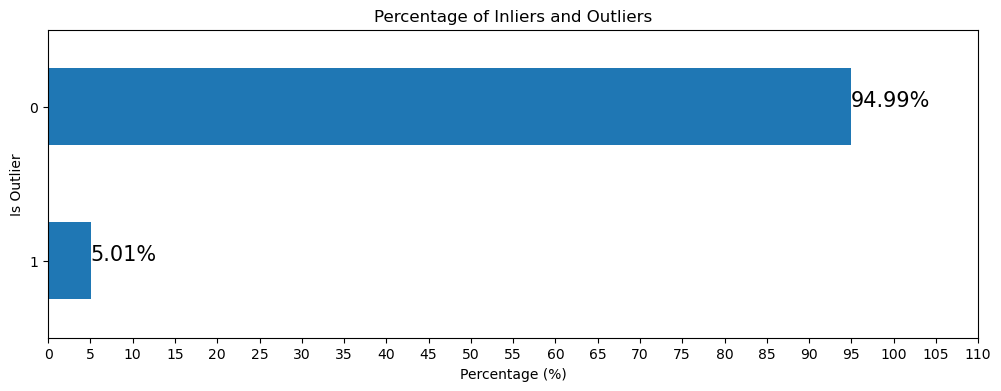

In [40]:
# Calculate the percentage of inliers and outliers
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Plotting the percentage of inliers and outliers
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh')

# Adding the percentage labels on the bars
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [41]:
# Separate the outliers for analysis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Remove the outliers from the main dataset
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Drop the 'Outlier_Scores' and 'Is_Outlier' columns
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Reset the index of the cleaned data
customer_data_cleaned.reset_index(drop=True, inplace=True)

In [42]:
# Getting the number of rows in the cleaned customer dataset
customer_data_cleaned.shape

(5478, 16)

# correlation analysis

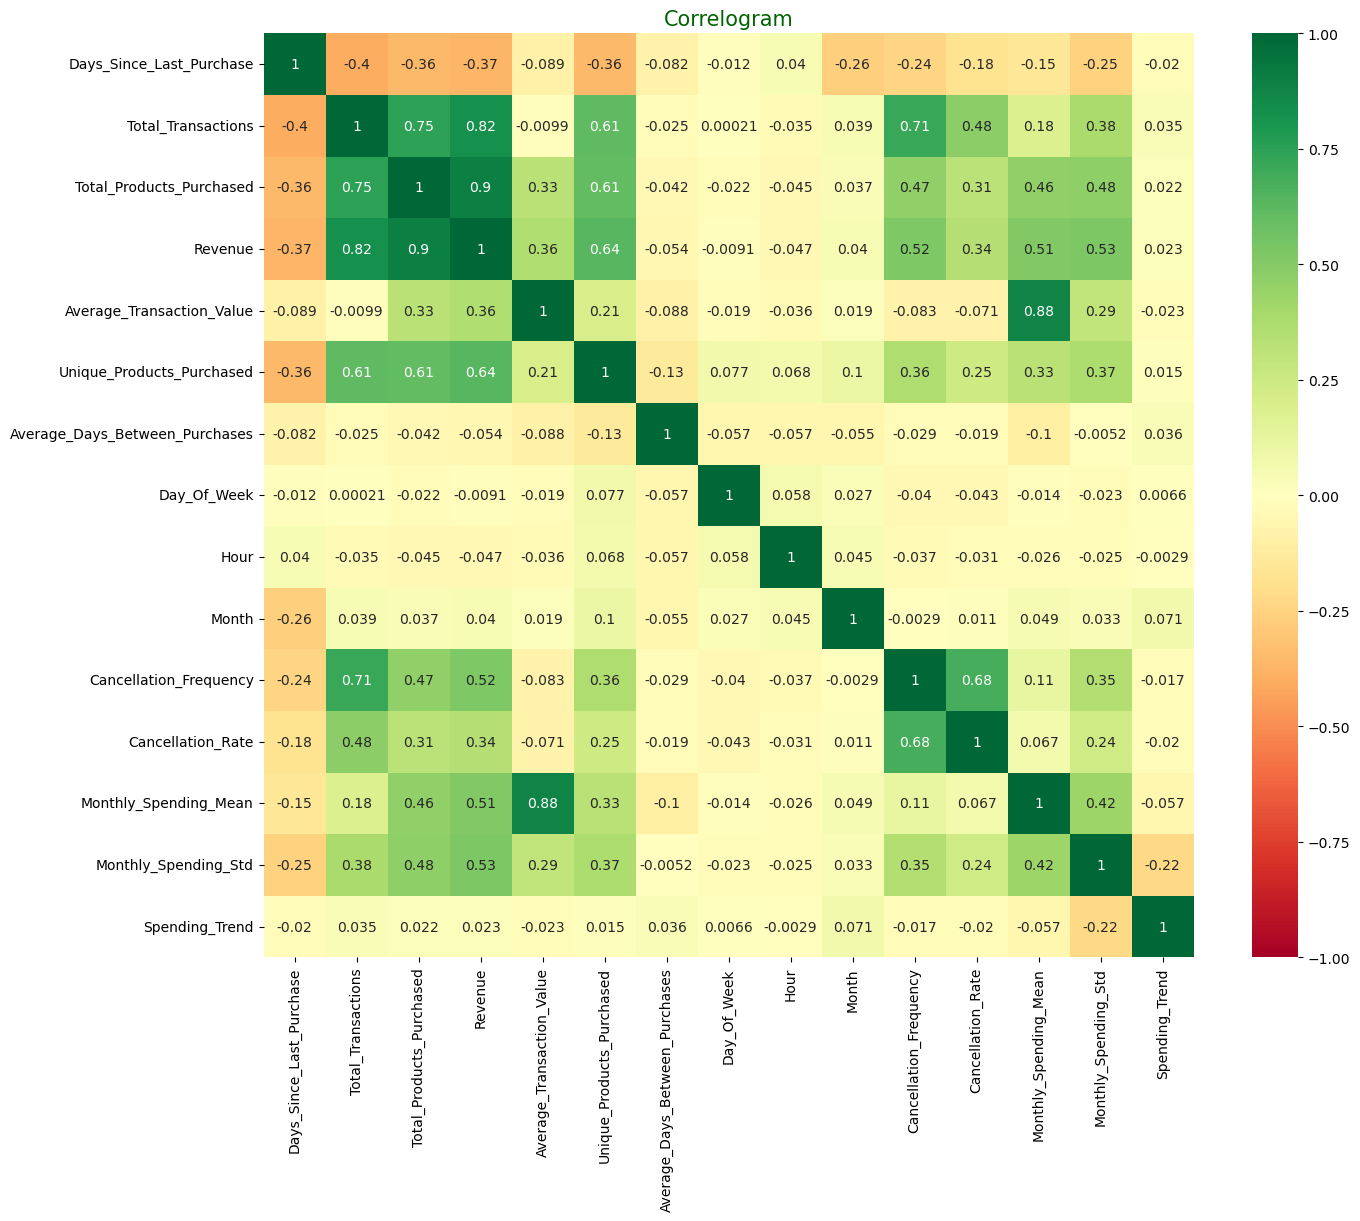

In [43]:
# Calculate the correlation matrix excluding the 'CustomerID' column
corr = customer_data_cleaned.drop(columns=['Customer ID']).corr()
plt.figure(figsize = (15, 12))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0,  vmin = -1,vmax= 1,)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

# Feature Scaling

In [44]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of columns that don't need to be scaled
columns_to_exclude = ['Customer ID', 'Day_Of_Week']

# List of columns that need to be scaled
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Copy the cleaned dataset
customer_data_scaled = customer_data_cleaned.copy()

# Applying the scaler to the necessary columns in the dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Display the first few rows of the scaled data
customer_data_scaled.head()

Customer ID  Days_Since_Last_Purchase  Total_Transactions  \
0       12346                  0.595490            1.338696   
1       12347                 -0.958385            0.372761   
2       12348                 -0.607199           -0.110206   
3       12349                 -0.881413           -0.271195   
4       12350                  0.523328           -0.754163   

   Total_Products_Purchased   Revenue  Average_Transaction_Value  \
0                 -0.677037 -0.585045                  -1.256941   
1                  1.621683  1.680923                   1.734765   
2                  1.413069  0.056967                   0.294433   
3                  0.550058  1.050382                   3.250959   
4                 -0.576300 -0.621853                   0.105038   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                  -0.557236                        0.369095            0   
1                   0.658787                       -0.207647            1   
2                  -0.594085                        0.167322            0   
3                   0.806184                       -0.072316            3   
4                  -0.692349                       -0.316819            2   

       Hour     Month  Cancellation_Frequency  Cancellation_Rate  \
0  0.189319 -0.473621                0.715040          -0.251386   
1  0.634611  0.703022               -0.563977          -0.419555   
2  0.634611  0.408861               -0.563977          -0.419555   
3 -1.591852  0.997182                0.075532          -0.125260   
4  1.525197 -1.650264               -0.563977          -0.419555   

   Monthly_Spending_Mean  Monthly_Spending_Std  Spending_Trend  
0              -1.137108             -0.402038        0.009287  
1               1.096078              0.853294        0.160860  
2              -0.047179              0.215974       -0.001856  
3               2.299551              2.494048        2.958190  
4              -0.197510             -0.710233        0.140082

# Dealing with Multi Collinierity through Dimensionality Reduction

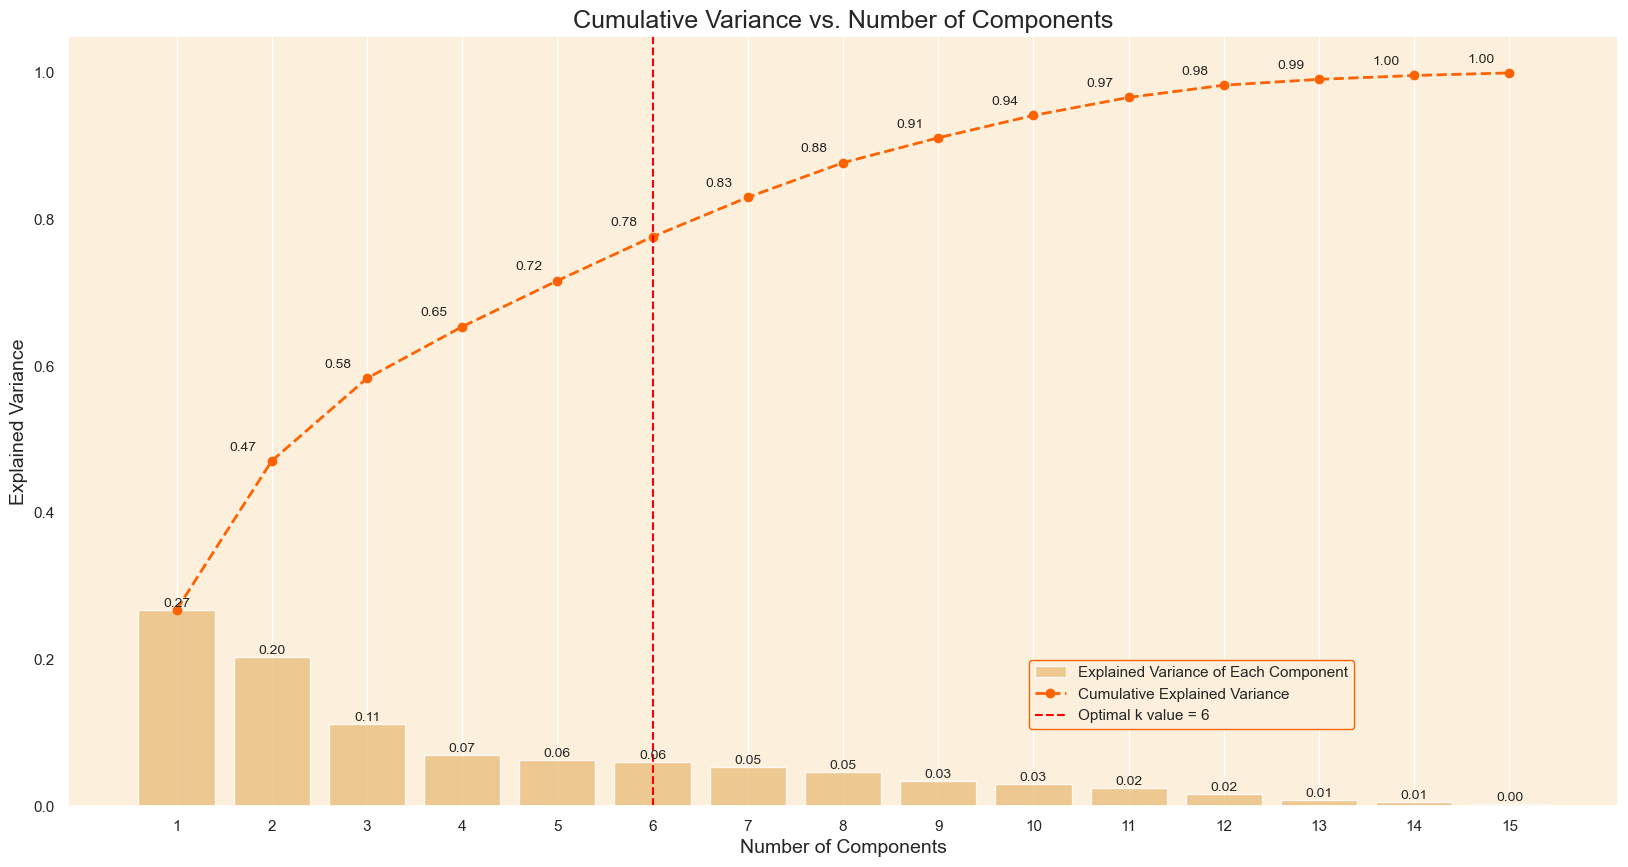

In [45]:
# Setting CustomerID as the index column
customer_data_scaled.set_index('Customer ID', inplace=True)

# Apply PCA
pca = PCA().fit(customer_data_scaled)

# Calculate the Cumulative Sum of the Explained Variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Set the optimal k value (based on our analysis, we can choose 6)
optimal_k = 6

# Set seaborn plot style
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plot the cumulative explained variance against the number of components
plt.figure(figsize=(20, 10))

# Bar chart for the explained variance of each component
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Line plot for the cumulative explained variance
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Plot optimal k value line
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}') 

# Set labels and title
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Customize ticks and legend
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,  
           edgecolor='#ff6200')  

# Display the variance values for both graphs on the plots
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')   
plt.show()

In [46]:
# Creating a PCA object with 6 components
pca = PCA(n_components=6)

# Fitting and transforming the original data to the new PCA dataframe
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Creating a new dataframe from the PCA dataframe, with columns labeled PC1, PC2, etc.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Adding the CustomerID index back to the new PCA dataframe
customer_data_pca.index = customer_data_scaled.index

In [47]:
# Displaying the resulting dataframe based on the PCs
customer_data_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6
Customer ID                                                            
12346       -0.753218  2.625363 -1.944150  0.358856 -0.164794 -0.232762
12347        2.589557  1.396874  2.063600 -1.168199 -0.298903  0.120967
12348        0.397032  2.533085  0.588502 -0.843166 -0.154856  0.377166
12349        2.945222 -0.470754  3.366445 -1.652185  1.633284 -1.364776
12350       -1.734028  0.587946  0.421965  0.796246 -0.959088 -0.839298

In [48]:
# Define a function to highlight the top 3 absolute values in each column of a dataframe
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

# Create the PCA component DataFrame and apply the highlighting function
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],  
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)

In [49]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

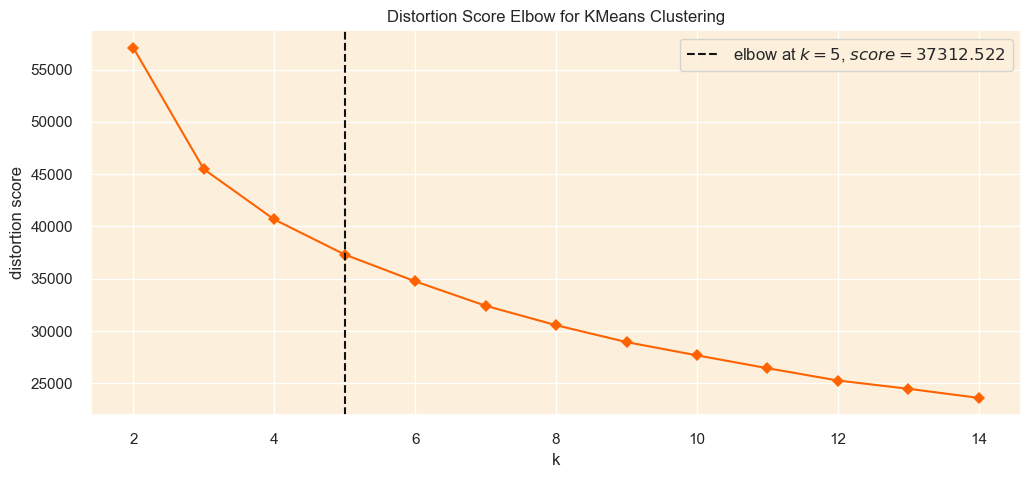

In [50]:
# Set plot style, and background color
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Set the color palette for the plot
sns.set_palette(['#ff6200'])

# Instantiate the clustering model with the specified parameters
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(12, 5))

# Instantiate the KElbowVisualizer with the model and range of k values, and disable the timing plot
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Fit the data to the visualizer
visualizer.fit(customer_data_pca)

# Finalize and render the figure
visualizer.show();

In [51]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Set the size of the figure
    plt.figure(figsize=figsize)

    # Create a grid with (stop_k - start_k + 1) rows and 2 columns
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Assign the first plot to the first row and both columns
    first_plot = plt.subplot(grid[0, :])

    # First plot: Silhouette scores for different k values
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Iterate through the range of k values
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)
    
      # Add the optimal k value text to the plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom', 
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))
             

    # Second plot (subplot): Silhouette plots for each k value
    colors = sns.color_palette("bright")

    plt.tight_layout()
    plt.show()

In [52]:
import matplotlib.gridspec as gridspec

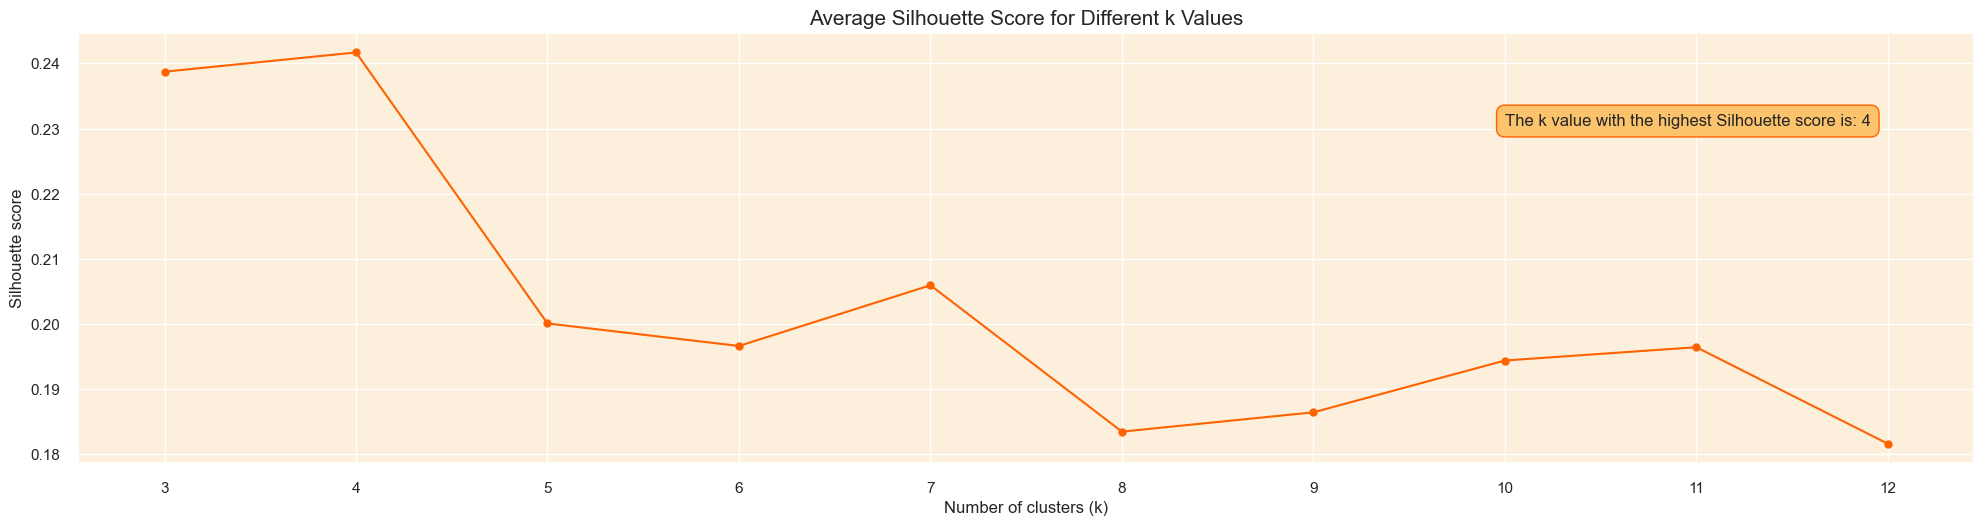

In [53]:
silhouette_analysis(customer_data_pca,3 , 12, figsize=(20, 50))

In [54]:
# Apply KMeans clustering using the optimal k
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

# Get the frequency of each cluster
cluster_frequencies = Counter(kmeans.labels_)

# Create a mapping from old labels to new labels based on frequency
label_mapping = {label: new_label for new_label, (label, _) in 
                 enumerate(cluster_frequencies.most_common())}

# Reverse the mapping to assign labels as per your criteria
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Apply the mapping to get the new labels
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Append the new cluster labels back to the original dataset
customer_data_cleaned['cluster'] = new_labels

# Append the new cluster labels to the PCA version of the dataset
customer_data_pca['cluster'] = new_labels

In [55]:
# Display the first few rows of the original dataframe
customer_data_cleaned.head()

Customer ID  Days_Since_Last_Purchase  Total_Transactions  \
0       12346                       325                  14   
1       12347                         2                   8   
2       12348                        75                   5   
3       12349                        18                   4   
4       12350                       310                   1   

   Total_Products_Purchased  Revenue  Average_Transaction_Value  \
0                        69   368.36                  26.311429   
1                      2967  4921.53                  615.19125   
2                      2704   1658.4                     331.68   
3                      1616  3654.54                    913.635   
4                       196    294.4                      294.4   

   Unique_Products_Purchased  Average_Days_Between_Purchases  Day_Of_Week  \
0                         27                       11.428571            0   
1                        126                        1.819005            1   
2                         24                        8.066667            0   
3                        138                        4.073864            3   
4                         16                             0.0            2   

   Hour  Month  Cancellation_Frequency  Cancellation_Rate  \
0    13      6                       2           0.142857   
1    14     10                       0                0.0   
2    14      9                       0                0.0   
3     9     11                       1               0.25   
4    16      2                       0                0.0   

   Monthly_Spending_Mean  Monthly_Spending_Std  Spending_Trend  cluster  
0              61.393333              62.24386      -21.021143        2  
1              615.19125            315.773658        3.339405        1  
2                 331.68            187.058966         -22.812        2  
3                913.635            647.144349          452.92        1  
4                  294.4                   0.0             0.0        2

In [56]:
# Setting up the color scheme for the clusters (RGB order)
colors = ['#e8000b', '#1ac938', '#023eff']
import plotly.graph_objects as go

In [57]:
# Create separate data frames for each cluster
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]

# Create a 3D scatter plot
fig = go.Figure()

# Add data points for each cluster separately and specify the color
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'], 
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'], 
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'], 
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()

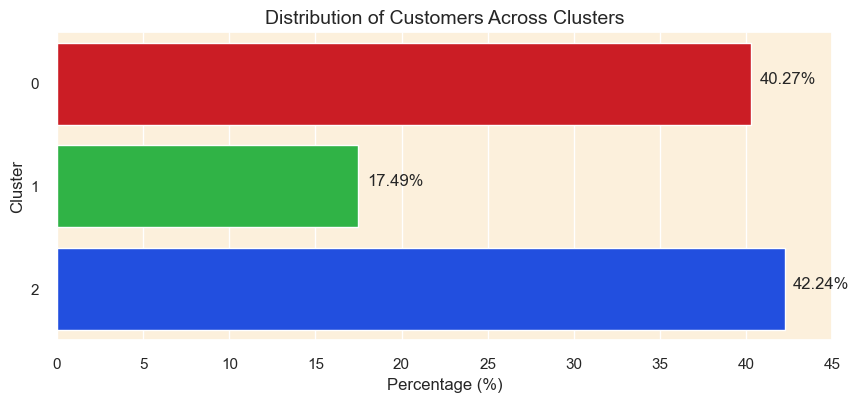

In [58]:
# Calculate the percentage of customers in each cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Create a horizontal bar plot
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Adding percentages on the bars
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Show the plot
plt.show()

In [59]:
#customer_data_pca.shape[0]
customer_data_cleaned.shape[0]

5478

In [60]:
# Compute number of customers
num_observations = len(customer_data_pca)

# Separate the features and the cluster labels
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Compute the metrics
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Create a table to display the metrics and the number of observations
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Print the table
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+--------------------+
|         Metric          |       Value        |
+-------------------------+--------------------+
| Number of Observations  |        5478        |
|    Silhouette Score     | 0.2387251613547546 |
| Calinski Harabasz Score | 1753.8891821629418 |
|  Davies Bouldin Score   | 1.375229385136197  |
+-------------------------+--------------------+


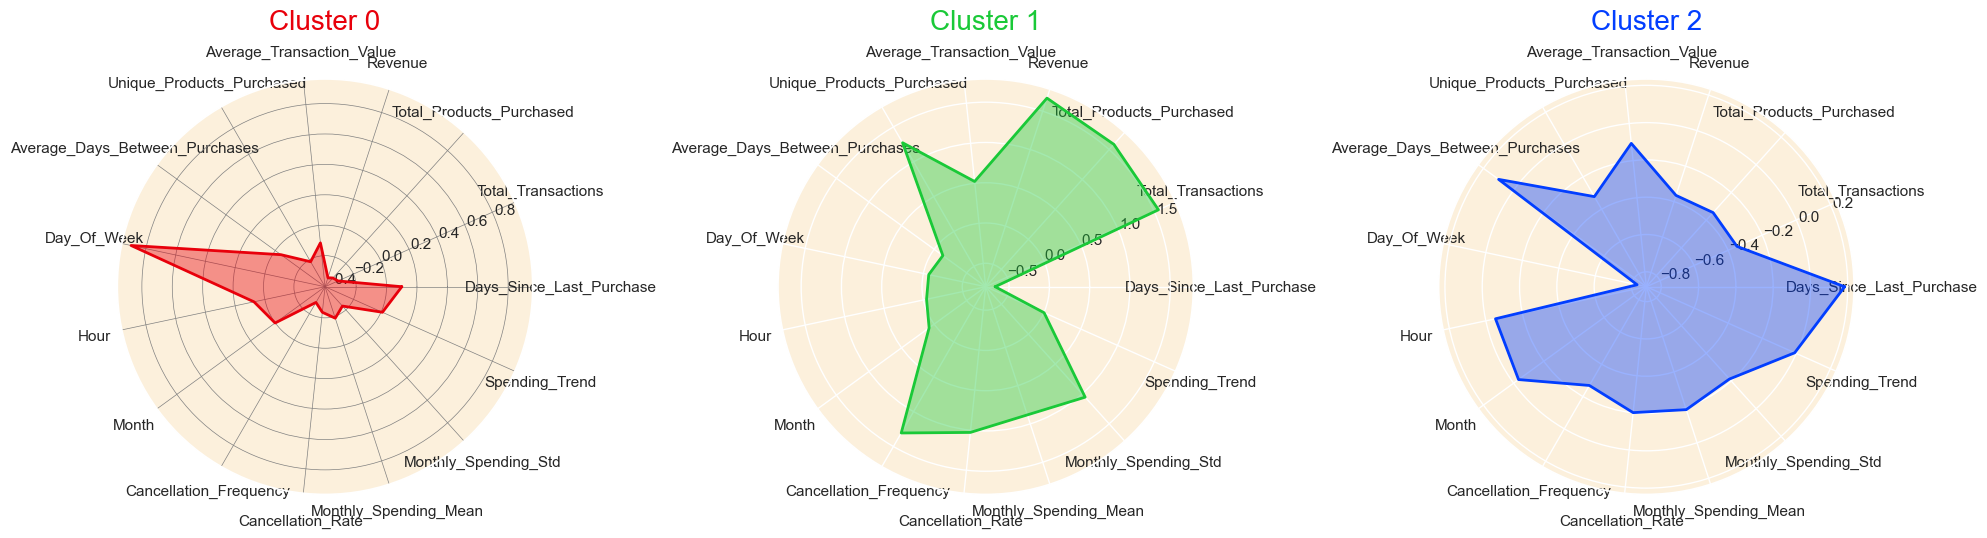

In [61]:
# Setting 'CustomerID' column as index and assigning it to a new dataframe
df_customer = customer_data_cleaned.set_index('Customer ID')

# Standardize the data (excluding the cluster column)
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

# Create a new dataframe with standardized values and add the cluster column back
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

# Calculate the centroids of each cluster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

# Function to create a radar chart
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')
    
    # Add a title
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Set data
labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# The plot is circular, so we need to "complete the loop" and append the start to the end
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Initialize the figure
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=3)

# Create radar chart for each cluster
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]  # Complete the loop
    create_radar_chart(ax[i], angles, data, color, i)

# Add input data
ax[0].set_xticks(angles[:-1])
ax[0].set_xticklabels(labels[:-1])

ax[1].set_xticks(angles[:-1])
ax[1].set_xticklabels(labels[:-1])

ax[2].set_xticks(angles[:-1])
ax[2].set_xticklabels(labels[:-1])

# Add a grid
ax[0].grid(color='grey', linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()

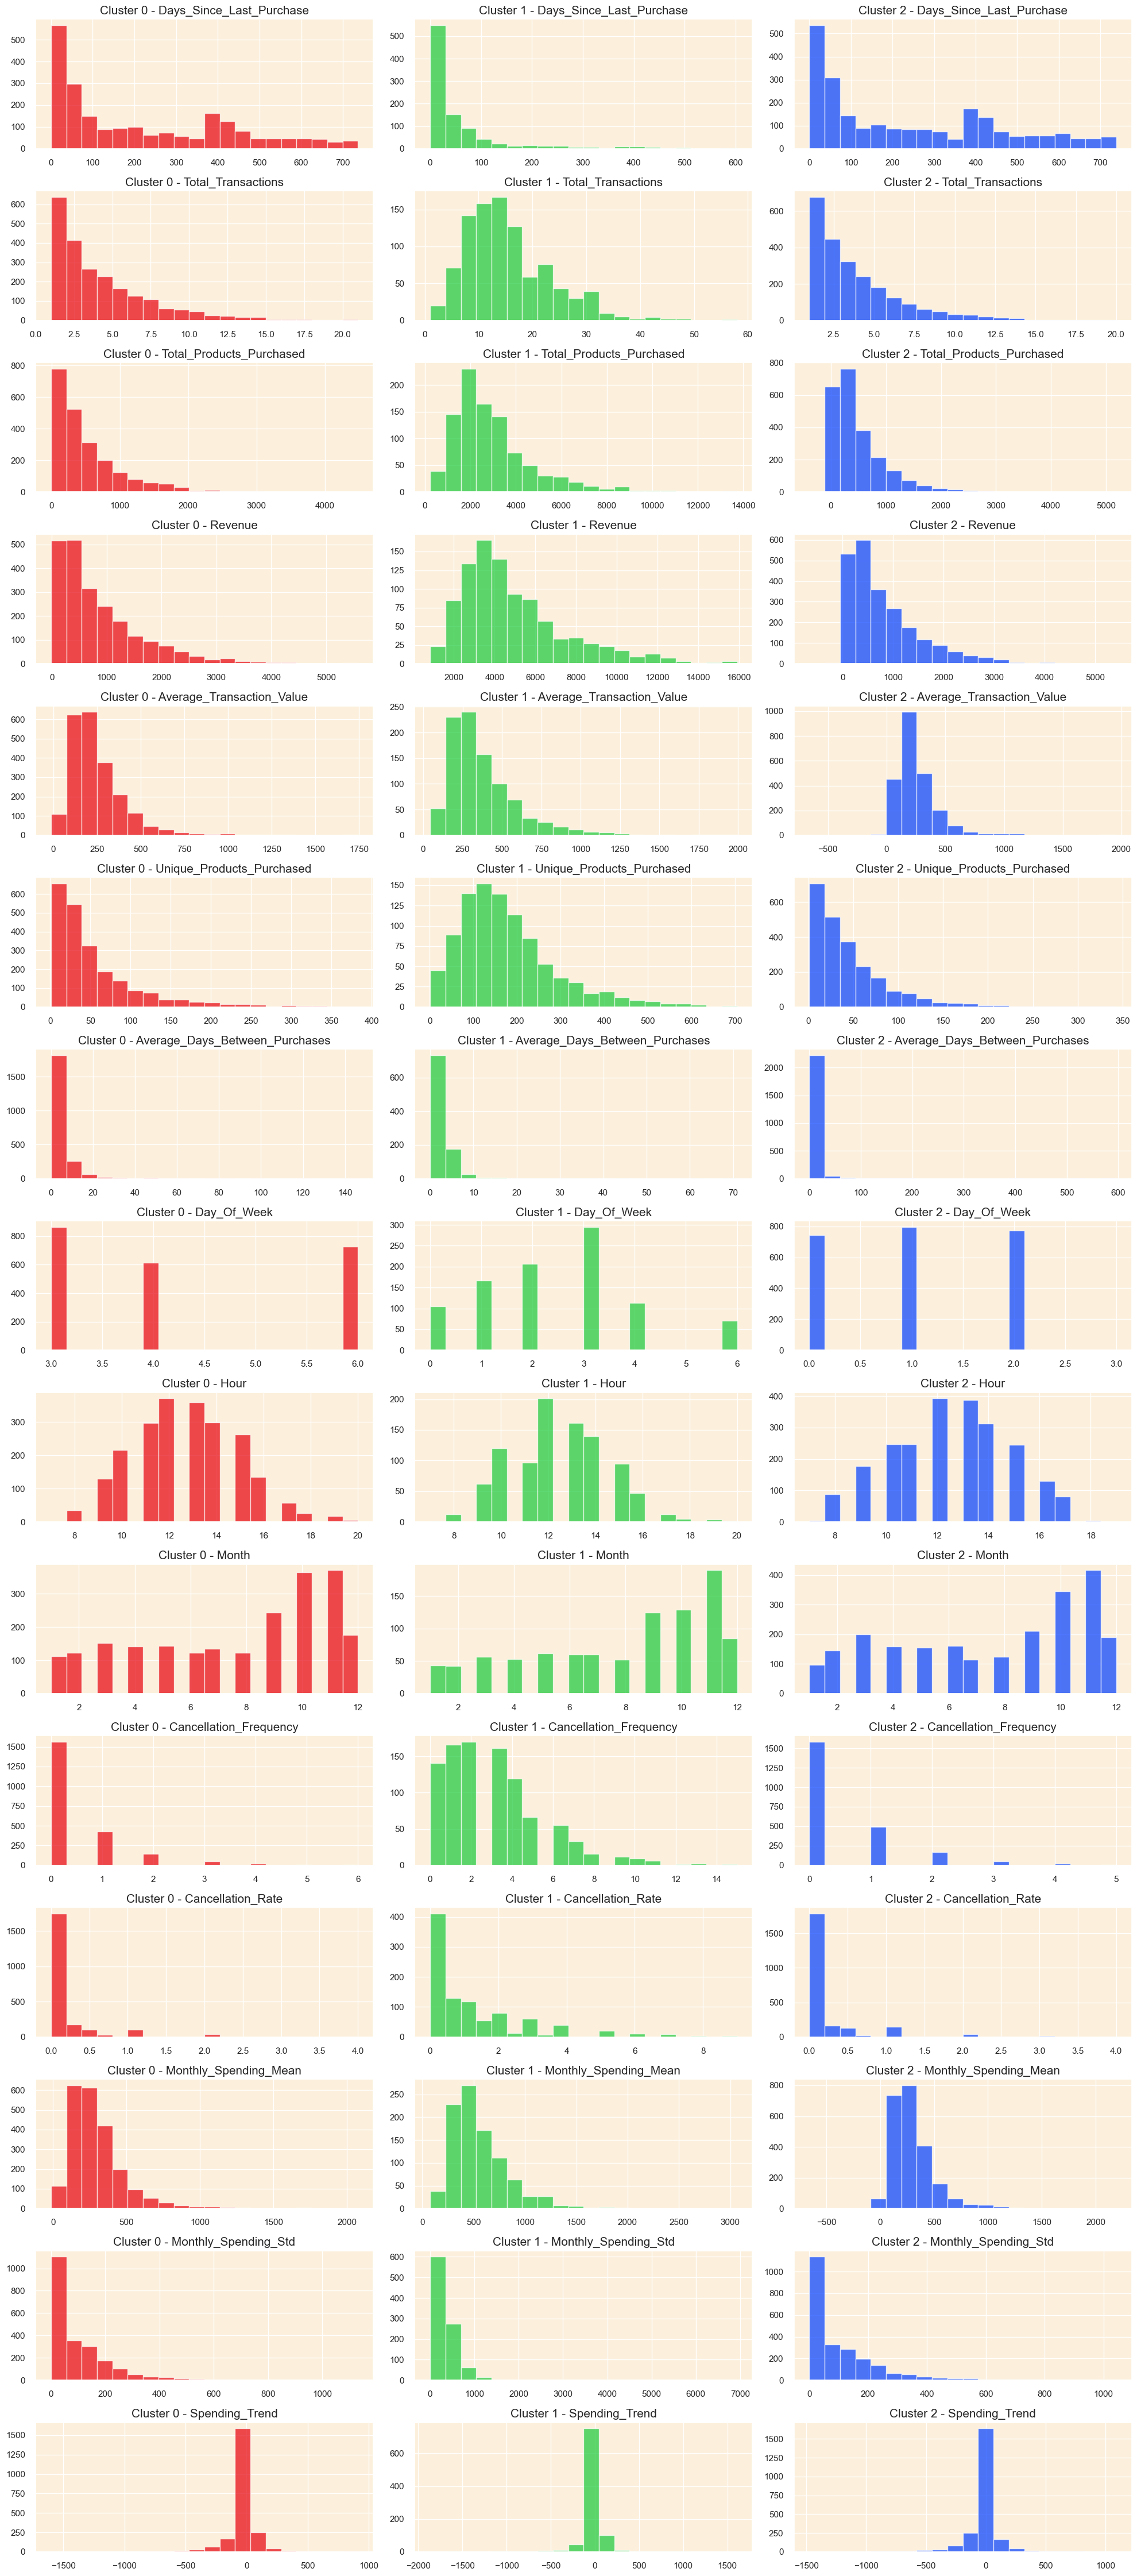

In [62]:
# Plot histograms for each feature segmented by the clusters
features = customer_data_cleaned.columns[1:-1]
clusters = customer_data_cleaned['cluster'].unique()
clusters.sort()

# Setting up the subplots
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

# Plotting histograms
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Adjusting layout to prevent overlapping
plt.tight_layout()
plt.show()

In [63]:
customer_data_cleaned.shape[0]

5478

In [64]:
customer_data_cleaned.shape[0]

5478

In [65]:
customer_data_cleaned.shape[0]

5478

In [66]:
# Step 1: Extract the CustomerIDs of the outliers and remove their transactions from the main dataframe
outlier_customer_ids = outliers_data['Customer ID'].astype('float').unique()
df_filtered = df[~df['Customer ID'].isin(outlier_customer_ids)]

# Step 2: Ensure consistent data type for CustomerID across both dataframes before merging
customer_data_cleaned['Customer ID'] = customer_data_cleaned['Customer ID'].astype('float')

df_filtered['Customer ID'] = df_filtered['Customer ID'].astype(float)

# Step 3: Merge the transaction data with the customer data to get the cluster information for each transaction
merged_data = df_filtered.merge(customer_data_cleaned[['Customer ID', 'cluster']], on='Customer ID', how='inner')
merged_data

Invoice StockCode                          Description  Quantity  \
0       489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1       489434    79323P                   PINK CHERRY LIGHTS        12   
2       489434    79323W                  WHITE CHERRY LIGHTS        12   
3       489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4       489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...        ...       ...                                  ...       ...   
565370  581578     22993         SET OF 4 PANTRY JELLY MOULDS        12   
565371  581578     22907     PACK OF 20 NAPKINS PANTRY DESIGN        12   
565372  581578     22908        PACK OF 20 NAPKINS RED APPLES        12   
565373  581578     23215     JINGLE BELL HEART ANTIQUE SILVER        12   
565374  581578     22736          RIBBON REEL MAKING SNOWMEN         10   

               InvoiceDate  Price  Customer ID         Country  \
0      2009-12-01 07:45:00   6.95      13085.0  United Kingdom   
1      2009-12-01 07:45:00   6.75      13085.0  United Kingdom   
2      2009-12-01 07:45:00   6.75      13085.0  United Kingdom   
3      2009-12-01 07:45:00   2.10      13085.0  United Kingdom   
4      2009-12-01 07:45:00   1.25      13085.0  United Kingdom   
...                    ...    ...          ...             ...   
565370 2011-12-09 12:16:00   1.25      12713.0         Germany   
565371 2011-12-09 12:16:00   0.85      12713.0         Germany   
565372 2011-12-09 12:16:00   0.85      12713.0         Germany   
565373 2011-12-09 12:16:00   2.08      12713.0         Germany   
565374 2011-12-09 12:16:00   1.65      12713.0         Germany   

       Transaction_Status  Revenue  InvoiceDay  Day_Of_Week  Hour  Month  \
0               Completed    83.40  2009-12-01            1     7     12   
1               Completed    81.00  2009-12-01            1     7     12   
2               Completed    81.00  2009-12-01            1     7     12   
3               Completed   100.80  2009-12-01            1     7     12   
4               Completed    30.00  2009-12-01            1     7     12   
...                   ...      ...         ...          ...   ...    ...   
565370          Completed    15.00  2011-12-09            4    12     12   
565371          Completed    10.20  2011-12-09            4    12     12   
565372          Completed    10.20  2011-12-09            4    12     12   
565373          Completed    24.96  2011-12-09            4    12     12   
565374          Completed    16.50  2011-12-09            4    12     12   

        Year  cluster  
0       2009        0  
1       2009        0  
2       2009        0  
3       2009        0  
4       2009        0  
...      ...      ...  
565370  2011        0  
565371  2011        0  
565372  2011        0  
565373  2011        0  
565374  2011        0  

[565375 rows x 16 columns]

In [67]:
clust0 = merged_data[merged_data['cluster'] == 0]
clust0 = clust0.groupby(['cluster','StockCode', 'Description','Price'])['Quantity'].sum().reset_index().sort_values(by='Quantity', ascending=False)
clust0 = clust0.nlargest(20,'Quantity')
clust0

cluster StockCode                          Description  Price  Quantity
5726        0     84879        ASSORTED COLOUR BIRD ORNAMENT   1.69      7243
5420        0     84568      GIRLS ALPHABET IRON ON PATCHES    0.21      6624
5238        0     84077    WORLD WAR 2 GLIDERS ASSTD DESIGNS   0.29      6099
6132        0    85123A   WHITE HANGING HEART T-LIGHT HOLDER   2.95      5695
6131        0    85123A   WHITE HANGING HEART T-LIGHT HOLDER   2.55      4746
2705        0     22492              MINI PAINT SET VINTAGE    0.65      4680
5673        0     84836          ZINC METAL HEART DECORATION   1.25      3801
5878        0     84991          60 TEATIME FAIRY CAKE CASES   0.55      3778
5581        0     84755  COLOUR GLASS T-LIGHT HOLDER HANGING   0.65      3534
5275        0     84270         ASSTD DESIGN BUBBLE GUM RING   0.21      3480
5454        0     84598        BOYS ALPHABET IRON ON PATCHES   0.21      3456
1584        0     21790                   VINTAGE SNAP CARDS   0.85      3244
5237        0     84077    WORLD WAR 2 GLIDERS ASSTD DESIGNS   0.21      3232
1824        0     21977   PACK OF 60 PINK PAISLEY CAKE CASES   0.55      3184
5852        0    84970S    HANGING HEART ZINC T-LIGHT HOLDER   0.85      3105
2137        0     22178      VICTORIAN GLASS HANGING T-LIGHT   1.25      3066
244         0     20668      DISCO BALL CHRISTMAS DECORATION   0.12      3048
2670        0     22469                HEART OF WICKER SMALL   1.65      2946
834         0     21212     PACK OF 72 RETRO SPOT CAKE CASES   0.55      2902
836         0     21212      PACK OF 72 RETROSPOT CAKE CASES   0.55      2705

In [68]:
clust1 = merged_data[merged_data['cluster'] == 1]
clust1 = clust1.groupby(['cluster','StockCode', 'Description','Price'])['Quantity'].sum().reset_index().sort_values(by='Quantity', ascending=False)
clust1 = clust1.nlargest(20,'Quantity')
clust1

cluster StockCode                          Description  Price  Quantity
6857        1     84879        ASSORTED COLOUR BIRD ORNAMENT   1.69     15672
7344        1    85123A   WHITE HANGING HEART T-LIGHT HOLDER   2.55     12739
6283        1     84077    WORLD WAR 2 GLIDERS ASSTD DESIGNS   0.29     12544
6282        1     84077    WORLD WAR 2 GLIDERS ASSTD DESIGNS   0.21     11114
3212        1     22492              MINI PAINT SET VINTAGE    0.65     10400
7063        1     84991          60 TEATIME FAIRY CAKE CASES   0.55     10296
2164        1     21977   PACK OF 60 PINK PAISLEY CAKE CASES   0.55     10206
7345        1    85123A   WHITE HANGING HEART T-LIGHT HOLDER   2.95     10114
3469        1     22616           PACK OF 12 LONDON TISSUES    0.25     10104
67          1     16014          SMALL CHINESE STYLE SCISSOR   0.32      9060
6321        1     84270         ASSTD DESIGN BUBBLE GUM RING   0.21      8970
1007        1     21212     PACK OF 72 RETRO SPOT CAKE CASES   0.55      8647
1009        1     21212      PACK OF 72 RETROSPOT CAKE CASES   0.55      8520
6677        1     84755  COLOUR GLASS T-LIGHT HOLDER HANGING   0.65      8335
2486        1     22151            PLACE SETTING WHITE HEART   0.42      8323
1037        1     21232       STRAWBERRY CERAMIC TRINKET BOX   1.25      7176
5910        1     72741                GRAND CHOCOLATECANDLE   1.25      7146
1012        1     21213          PACK OF 72 SKULL CAKE CASES   0.55      6836
1899        1     21790                   VINTAGE SNAP CARDS   0.85      6534
181         1     17003                  BROCADE RING PURSE    0.16      6480

In [69]:
clust2 = merged_data[merged_data['cluster'] == 2]
clust2 = clust2.groupby(['cluster','StockCode', 'Description','Price'])['Quantity'].sum().reset_index().sort_values(by='Quantity', ascending=False)
clust2 = clust2.nlargest(20,'Quantity')
clust2

cluster StockCode                          Description  Price  Quantity
5814        2     84879        ASSORTED COLOUR BIRD ORNAMENT   1.69      7039
6231        2    85123A   WHITE HANGING HEART T-LIGHT HOLDER   2.95      5405
5335        2     84270         ASSTD DESIGN BUBBLE GUM RING   0.21      4530
5300        2     84077    WORLD WAR 2 GLIDERS ASSTD DESIGNS   0.29      4487
192         2     17096    ASSORTED LAQUERED INCENSE HOLDERS   0.17      4323
5971        2     84991          60 TEATIME FAIRY CAKE CASES   0.55      4285
2771        2     22492              MINI PAINT SET VINTAGE    0.65      4212
6230        2    85123A   WHITE HANGING HEART T-LIGHT HOLDER   2.55      3959
1849        2     21977   PACK OF 60 PINK PAISLEY CAKE CASES   0.55      3899
841         2     21212      PACK OF 72 RETROSPOT CAKE CASES   0.55      3271
839         2     21212     PACK OF 72 RETRO SPOT CAKE CASES   0.55      3184
867         2     21232       STRAWBERRY CERAMIC TRINKET BOX   1.25      3165
5650        2     84755  COLOUR GLASS T-LIGHT HOLDER HANGING   0.65      3097
5902        2     84947    ANTIQUE SILVER TEA GLASS ENGRAVED   1.06      3024
5750        2     84836          ZINC METAL HEART DECORATION   1.25      2961
60          2     16045           POPART WOODEN PENCILS ASST   0.04      2900
2736        2     22469                HEART OF WICKER SMALL   1.65      2891
5945        2    84970S    HANGING HEART ZINC T-LIGHT HOLDER   0.85      2873
843         2     21213          PACK OF 72 SKULL CAKE CASES   0.55      2748
1871        2     21985    PACK OF 12 HEARTS DESIGN TISSUES    0.29      2712

In [70]:
frames = [clust0,clust1,clust2]
fl_df = pd.concat(frames).reset_index()
fl_df

index  cluster StockCode                          Description  Price  \
0    5726        0     84879        ASSORTED COLOUR BIRD ORNAMENT   1.69   
1    5420        0     84568      GIRLS ALPHABET IRON ON PATCHES    0.21   
2    5238        0     84077    WORLD WAR 2 GLIDERS ASSTD DESIGNS   0.29   
3    6132        0    85123A   WHITE HANGING HEART T-LIGHT HOLDER   2.95   
4    6131        0    85123A   WHITE HANGING HEART T-LIGHT HOLDER   2.55   
5    2705        0     22492              MINI PAINT SET VINTAGE    0.65   
6    5673        0     84836          ZINC METAL HEART DECORATION   1.25   
7    5878        0     84991          60 TEATIME FAIRY CAKE CASES   0.55   
8    5581        0     84755  COLOUR GLASS T-LIGHT HOLDER HANGING   0.65   
9    5275        0     84270         ASSTD DESIGN BUBBLE GUM RING   0.21   
10   5454        0     84598        BOYS ALPHABET IRON ON PATCHES   0.21   
11   1584        0     21790                   VINTAGE SNAP CARDS   0.85   
12   5237        0     84077    WORLD WAR 2 GLIDERS ASSTD DESIGNS   0.21   
13   1824        0     21977   PACK OF 60 PINK PAISLEY CAKE CASES   0.55   
14   5852        0    84970S    HANGING HEART ZINC T-LIGHT HOLDER   0.85   
15   2137        0     22178      VICTORIAN GLASS HANGING T-LIGHT   1.25   
16    244        0     20668      DISCO BALL CHRISTMAS DECORATION   0.12   
17   2670        0     22469                HEART OF WICKER SMALL   1.65   
18    834        0     21212     PACK OF 72 RETRO SPOT CAKE CASES   0.55   
19    836        0     21212      PACK OF 72 RETROSPOT CAKE CASES   0.55   
20   6857        1     84879        ASSORTED COLOUR BIRD ORNAMENT   1.69   
21   7344        1    85123A   WHITE HANGING HEART T-LIGHT HOLDER   2.55   
22   6283        1     84077    WORLD WAR 2 GLIDERS ASSTD DESIGNS   0.29   
23   6282        1     84077    WORLD WAR 2 GLIDERS ASSTD DESIGNS   0.21   
24   3212        1     22492              MINI PAINT SET VINTAGE    0.65   
25   7063        1     84991          60 TEATIME FAIRY CAKE CASES   0.55   
26   2164        1     21977   PACK OF 60 PINK PAISLEY CAKE CASES   0.55   
27   7345        1    85123A   WHITE HANGING HEART T-LIGHT HOLDER   2.95   
28   3469        1     22616           PACK OF 12 LONDON TISSUES    0.25   
29     67        1     16014          SMALL CHINESE STYLE SCISSOR   0.32   
30   6321        1     84270         ASSTD DESIGN BUBBLE GUM RING   0.21   
31   1007        1     21212     PACK OF 72 RETRO SPOT CAKE CASES   0.55   
32   1009        1     21212      PACK OF 72 RETROSPOT CAKE CASES   0.55   
33   6677        1     84755  COLOUR GLASS T-LIGHT HOLDER HANGING   0.65   
34   2486        1     22151            PLACE SETTING WHITE HEART   0.42   
35   1037        1     21232       STRAWBERRY CERAMIC TRINKET BOX   1.25   
36   5910        1     72741                GRAND CHOCOLATECANDLE   1.25   
37   1012        1     21213          PACK OF 72 SKULL CAKE CASES   0.55   
38   1899        1     21790                   VINTAGE SNAP CARDS   0.85   
39    181        1     17003                  BROCADE RING PURSE    0.16   
40   5814        2     84879        ASSORTED COLOUR BIRD ORNAMENT   1.69   
41   6231        2    85123A   WHITE HANGING HEART T-LIGHT HOLDER   2.95   
42   5335        2     84270         ASSTD DESIGN BUBBLE GUM RING   0.21   
43   5300        2     84077    WORLD WAR 2 GLIDERS ASSTD DESIGNS   0.29   
44    192        2     17096    ASSORTED LAQUERED INCENSE HOLDERS   0.17   
45   5971        2     84991          60 TEATIME FAIRY CAKE CASES   0.55   
46   2771        2     22492              MINI PAINT SET VINTAGE    0.65   
47   6230        2    85123A   WHITE HANGING HEART T-LIGHT HOLDER   2.55   
48   1849        2     21977   PACK OF 60 PINK PAISLEY CAKE CASES   0.55   
49    841        2     21212      PACK OF 72 RETROSPOT CAKE CASES   0.55   
50    839        2     21212     PACK OF 72 RETRO SPOT CAKE CASES   0.55   
51    867        2     21232       STRAWBERRY CERAMI

In [71]:
import random

In [72]:
# Step 4: Identify the top 10 best-selling products in each cluster based on the total quantity sold
best_selling_products = merged_data.groupby(['cluster', 'StockCode', 'Description','Price'])['Quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['cluster', 'Quantity'], ascending=[True,False])
top_products_per_cluster = best_selling_products.groupby('cluster').head(10)

# # Step 5: Create a record of products purchased by each customer in each cluster
customer_purchases = merged_data.groupby(['Customer ID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

# Step 6: Generate recommendations for each customer in each cluster
recommendations = []
for cluster in fl_df['cluster'].unique():
    top_products = fl_df[fl_df['cluster'] == cluster]
    customers_in_cluster = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['Customer ID']
    
    for customer in customers_in_cluster:
        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases['Customer ID'] == customer) & 
                                                         (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()     
        
        # Find top 3 products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.tail(3)
        
        # Append the recommendations to the list
        recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description','Quantity','Price']].values.flatten().tolist())

# Step 7: Create a dataframe from the recommendations list and merge it with the original customer data
recommendations_df = pd.DataFrame(recommendations, columns=['Customer ID', 'cluster', 'Rec1_StockCode', 'Rec1_Description','Rec1_Quantity','Rec1_Price', \
                                                 'Rec2_StockCode', 'Rec2_Description','Rec2_Quantity','Rec2_Price', 'Rec3_StockCode', 'Rec3_Description','Rec3_Quantity','Rec3_Price'])
customer_data_with_recommendations = customer_data_cleaned.merge(recommendations_df, on=['Customer ID', 'cluster'], how='right')


In [73]:
top_products.nunique()


index          20
cluster         1
StockCode      18
Description    19
Price          13
Quantity       20
dtype: int64

In [74]:
top_products.head(20)


index  cluster StockCode                          Description  Price  \
40   5814        2     84879        ASSORTED COLOUR BIRD ORNAMENT   1.69   
41   6231        2    85123A   WHITE HANGING HEART T-LIGHT HOLDER   2.95   
42   5335        2     84270         ASSTD DESIGN BUBBLE GUM RING   0.21   
43   5300        2     84077    WORLD WAR 2 GLIDERS ASSTD DESIGNS   0.29   
44    192        2     17096    ASSORTED LAQUERED INCENSE HOLDERS   0.17   
45   5971        2     84991          60 TEATIME FAIRY CAKE CASES   0.55   
46   2771        2     22492              MINI PAINT SET VINTAGE    0.65   
47   6230        2    85123A   WHITE HANGING HEART T-LIGHT HOLDER   2.55   
48   1849        2     21977   PACK OF 60 PINK PAISLEY CAKE CASES   0.55   
49    841        2     21212      PACK OF 72 RETROSPOT CAKE CASES   0.55   
50    839        2     21212     PACK OF 72 RETRO SPOT CAKE CASES   0.55   
51    867        2     21232       STRAWBERRY CERAMIC TRINKET BOX   1.25   
52   5650        2     84755  COLOUR GLASS T-LIGHT HOLDER HANGING   0.65   
53   5902        2     84947    ANTIQUE SILVER TEA GLASS ENGRAVED   1.06   
54   5750        2     84836          ZINC METAL HEART DECORATION   1.25   
55     60        2     16045           POPART WOODEN PENCILS ASST   0.04   
56   2736        2     22469                HEART OF WICKER SMALL   1.65   
57   5945        2    84970S    HANGING HEART ZINC T-LIGHT HOLDER   0.85   
58    843        2     21213          PACK OF 72 SKULL CAKE CASES   0.55   
59   1871        2     21985    PACK OF 12 HEARTS DESIGN TISSUES    0.29   

    Quantity  
40      7039  
41      5405  
42      4530  
43      4487  
44      4323  
45      4285  
46      4212  
47      3959  
48      3899  
49      3271  
50      3184  
51      3165  
52      3097  
53      3024  
54      2961  
55      2900  
56      2891  
57      2873  
58      2748  
59      2712

In [75]:
customer_purchases.shape

(396422, 4)

In [76]:
merged_data.nunique()

Invoice               31140
StockCode              4564
Description            5161
Quantity                355
InvoiceDate           29445
Price                   222
Customer ID            5478
Country                  39
Transaction_Status        2
Revenue                2944
InvoiceDay              604
Day_Of_Week               7
Hour                     16
Month                    12
Year                      3
cluster                   3
dtype: int64

In [77]:
# Display 10 random rows from the customer_data_with_recommendations dataframe
customer_data_with_recommendations.set_index('Customer ID').iloc[:,-13: ].sample(30, random_state=0)

cluster Rec1_StockCode                   Rec1_Description  \
Customer ID                                                              
16162.0            0          22469              HEART OF WICKER SMALL   
12493.0            0          22469              HEART OF WICKER SMALL   
12403.0            0          22469              HEART OF WICKER SMALL   
16625.0            2         84970S  HANGING HEART ZINC T-LIGHT HOLDER   
18092.0            1          21213        PACK OF 72 SKULL CAKE CASES   
17476.0            2         84970S  HANGING HEART ZINC T-LIGHT HOLDER   
14759.0            2         84970S  HANGING HEART ZINC T-LIGHT HOLDER   
16431.0            2         84970S  HANGING HEART ZINC T-LIGHT HOLDER   
13284.0            0          22178    VICTORIAN GLASS HANGING T-LIGHT   
12888.0            2         84970S  HANGING HEART ZINC T-LIGHT HOLDER   
16520.0            0          22469              HEART OF WICKER SMALL   
14610.0            2         84970S  HANGING HEART ZINC T-LIGHT HOLDER   
15461.0            2         84970S  HANGING HEART ZINC T-LIGHT HOLDER   
15986.0            2         84970S  HANGING HEART ZINC T-LIGHT HOLDER   
18254.0            0          22469              HEART OF WICKER SMALL   
13315.0            2         84970S  HANGING HEART ZINC T-LIGHT HOLDER   
16149.0            2         84970S  HANGING HEART ZINC T-LIGHT HOLDER   
15662.0            2         84970S  HANGING HEART ZINC T-LIGHT HOLDER   
18120.0            2         84970S  HANGING HEART ZINC T-LIGHT HOLDER   
14247.0            0          20668    DISCO BALL CHRISTMAS DECORATION   
14966.0            2         84970S  HANGING HEART ZINC T-LIGHT HOLDER   
16334.0            2         84970S  HANGING HEART ZINC T-LIGHT HOLDER   
17710.0            2         84970S  HANGING HEART ZINC T-LIGHT HOLDER   
12502.0            0          22469              HEART OF WICKER SMALL   
17197.0            0          22469              HEART OF WICKER SMALL   
17344.0            0          22469              HEART OF WICKER SMALL   
14376.0            2         84970S  HANGING HEART ZINC T-LIGHT HOLDER   
17405.0            2         84970S  HANGING HEART ZINC T-LIGHT HOLDER   
13396.0            0          22178    VICTORIAN GLASS HANGING T-LIGHT   
12935.0            1          72741              GRAND CHOCOLATECANDLE   

             Rec1_Quantity  Rec1_Price Rec2_StockCode  \
Customer ID                                             
16162.0               2946        1.65          21212   
12493.0               2946        1.65          21212   
12403.0               2946        1.65          21212   
16625.0               2873        0.85          21213   
18092.0               6836        0.55          21790   
17476.0               2873        0.85          21213   
14759.0               2873        0.85          21213   
16431.0               2873        0.85          21213   
13284.0               3066        1.25          20668   
12888.0               2873        0.85          21213   
16520.0               2946        1.65          21212   
14610.0               2873        0.85          21213   
15461.0               2873        0.85          21213   
15986.0               2873        0.85          21213   
18254.0               2946        1.65          21212   
13315.0               2873        0.85          21213   
16149.0               2873        0.85          21213   
15662.0               2873        0.85          21213   
18120.0               2873        0.85          21213   
14247.0               3048        0.12          21212   
14966.0               2873        0.85          21213   
16334.0               2873        0.85          21213   
17710.0               2873        0.85          21213   
12502.0               2946        1.65          21212   
17197.0               2946        1.65          21212   
17344.0               2946        1.65          21212   
14376.0               2873        0.85          

In [78]:

# Step 4: Identify the top 10 best-selling products in each cluster based on the total quantity sold
least_selling_products = merged_data.groupby(['cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
least_selling_products = least_selling_products.sort_values(by=['cluster', 'Quantity'], ascending=[True,True])
btm_products_per_cluster = least_selling_products.groupby('cluster').head(10)

# Step 5: Create a record of products purchased by each customer in each cluster
customer_purchases = merged_data.groupby(['Customer ID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

# Step 6: Generate recommendations for each customer in each cluster
recommendationss = []
for cluster in btm_products_per_cluster['cluster'].unique():
    top_products = btm_products_per_cluster[btm_products_per_cluster['cluster'] == cluster]
    customers_in_cluster = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['Customer ID']
    
    for customer in customers_in_cluster:
        # Identify products already purchased by the customer
        customer_purchased_products = customer_purchases[(customer_purchases['Customer ID'] == customer) & 
                                                         (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()
        
        # Find top 3 products in the best-selling list that the customer hasn't purchased yet
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)
        
        # Append the recommendations to the list
        recommendationss.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())

# Step 7: Create a dataframe from the recommendations list and merge it with the original customer data
recommendationss_df = pd.DataFrame(recommendationss, columns=['Customer ID', 'cluster', 'Rec1_StockCode', 'Rec1_Description', \
                                                 'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])
customer_data_with_recommendationss = customer_data_cleaned.merge(recommendationss_df, on=['Customer ID', 'cluster'], how='right')

In [79]:
# Display 10 random rows from the customer_data_with_recommendations dataframe
customer_data_with_recommendationss.set_index('Customer ID').iloc[:, -7:].sample(50, random_state=0)

cluster Rec1_StockCode                     Rec1_Description  \
Customer ID                                                                
16162.0            0         79323S                 SILVER CHERRY LIGHTS   
12493.0            0         79323S                 SILVER CHERRY LIGHTS   
12403.0            0         79323S                 SILVER CHERRY LIGHTS   
16625.0            2          20879  TREE OF NOAH FESTIVE SCENTED CANDLE   
18092.0            1          21392            RED POLKADOT PUDDING BOWL   
17476.0            2          20879  TREE OF NOAH FESTIVE SCENTED CANDLE   
14759.0            2          20879  TREE OF NOAH FESTIVE SCENTED CANDLE   
16431.0            2          20879  TREE OF NOAH FESTIVE SCENTED CANDLE   
13284.0            0         79323S                 SILVER CHERRY LIGHTS   
12888.0            2          20879  TREE OF NOAH FESTIVE SCENTED CANDLE   
16520.0            0         79323S                 SILVER CHERRY LIGHTS   
14610.0            2          20879  TREE OF NOAH FESTIVE SCENTED CANDLE   
15461.0            2          20879  TREE OF NOAH FESTIVE SCENTED CANDLE   
15986.0            2          20879  TREE OF NOAH FESTIVE SCENTED CANDLE   
18254.0            0         79323S                 SILVER CHERRY LIGHTS   
13315.0            2          20879  TREE OF NOAH FESTIVE SCENTED CANDLE   
16149.0            2          20879  TREE OF NOAH FESTIVE SCENTED CANDLE   
15662.0            2          20879  TREE OF NOAH FESTIVE SCENTED CANDLE   
18120.0            2          20879  TREE OF NOAH FESTIVE SCENTED CANDLE   
14247.0            0         79323S                 SILVER CHERRY LIGHTS   
14966.0            2          21701  SET 6 MINI SUSHI SET FRIDGE MAGNETS   
16334.0            2          20879  TREE OF NOAH FESTIVE SCENTED CANDLE   
17710.0            2          20879  TREE OF NOAH FESTIVE SCENTED CANDLE   
12502.0            0         79323S                 SILVER CHERRY LIGHTS   
17197.0            0         79323S                 SILVER CHERRY LIGHTS   
17344.0            0         79323S                 SILVER CHERRY LIGHTS   
14376.0            2          20879  TREE OF NOAH FESTIVE SCENTED CANDLE   
17405.0            2          20879  TREE OF NOAH FESTIVE SCENTED CANDLE   
13396.0            0         79323S                 SILVER CHERRY LIGHTS   
12935.0            1          21392            RED POLKADOT PUDDING BOWL   
17767.0            0         79323S                 SILVER CHERRY LIGHTS   
15597.0            0         79323S                 SILVER CHERRY LIGHTS   
14644.0            1          21392            RED POLKADOT PUDDING BOWL   
16919.0            1          21392            RED POLKADOT PUDDING BOWL   
12881.0            2          20879  TREE OF NOAH FESTIVE SCENTED CANDLE   
12833.0            0         79323S                 SILVER CHERRY LIGHTS   
16956.0            2          20879  TREE OF NOAH FESTIVE SCENTED CANDLE   
17634.0            0         79323S                 SILVER CHERRY LIGHTS   
15307.0            2          20879  TREE OF NOAH FESTIVE SCENTED CANDLE   
12960.0            2          20879  TREE OF NOAH FESTIVE SCENTED CANDLE   
16014.0            0         79323S                 SILVER CHERRY LIGHTS   
16177.0            1          21392            RED POLKADOT PUDDING BOWL   
15415.0            0         79323S                 SILVER CHERRY LIGHTS   
13271.0            2          20879  TREE OF NOAH FESTIVE SCENTED CANDLE   
15816.0            2          20879  TREE OF NOAH FESTIVE SCENTED CANDLE   
13183.0            1          21392            RED POLKADOT PUDDING BOWL   
13990.0            2          20879  TREE OF NOAH FESTIVE SCENTED CANDLE   
17760.0            2          20879  TREE OF NOAH FESTIVE SCENTED CANDLE   
17478.0            2          20879  TREE OF NOAH FESTIVE SCENTED CANDLE   
13735.0            1          21392            RED POLKADOT PUDDING BOWL   

            Rec2_StockCode                     Rec2_Descript

# Apriori Algorithm

In [80]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


In [81]:
df

Invoice StockCode                          Description  Quantity  \
0       489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1       489434    79323P                   PINK CHERRY LIGHTS        12   
2       489434    79323W                  WHITE CHERRY LIGHTS        12   
3       489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4       489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
...        ...       ...                                  ...       ...   
794091  581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
794092  581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
794093  581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
794094  581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
794095  581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  Price Customer ID         Country  \
0      2009-12-01 07:45:00   6.95       13085  United Kingdom   
1      2009-12-01 07:45:00   6.75       13085  United Kingdom   
2      2009-12-01 07:45:00   6.75       13085  United Kingdom   
3      2009-12-01 07:45:00   2.10       13085  United Kingdom   
4      2009-12-01 07:45:00   1.25       13085  United Kingdom   
...                    ...    ...         ...             ...   
794091 2011-12-09 12:50:00   0.85       12680          France   
794092 2011-12-09 12:50:00   2.10       12680          France   
794093 2011-12-09 12:50:00   4.15       12680          France   
794094 2011-12-09 12:50:00   4.15       12680          France   
794095 2011-12-09 12:50:00   4.95       12680          France   

       Transaction_Status  Revenue  InvoiceDay  Day_Of_Week  Hour  Month  Year  
0               Completed    83.40  2009-12-01            1     7     12  2009  
1               Completed    81.00  2009-12-01            1     7     12  2009  
2               Completed    81.00  2009-12-01            1     7     12  2009  
3               Completed   100.80  2009-12-01            1     7     12  2009  
4               Completed    30.00  2009-12-01            1     7     12  2009  
...                   ...      ...         ...          ...   ...    ...   ...  
794091          Completed    10.20  2011-12-09            4    12     12  2011  
794092          Completed    12.60  2011-12-09            4    12     12  2011  
794093          Completed    16.60  2011-12-09            4    12     12  2011  
794094          Completed    16.60  2011-12-09            4    12     12  2011  
794095          Completed    14.85  2011-12-09            4    12     12  2011  

[794096 rows x 15 columns]

In [82]:
df['Description'] = df['Description'].str.strip()

In [83]:
df['Invoice'] = df['Invoice'].astype('str')

In [84]:
basket = (df[df['Country'] == "France"]
          .groupby(['Invoice', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0).set_index('Invoice'))

In [85]:
basket.head()

Description  10 COLOUR SPACEBOY PEN  12 COLOURED PARTY BALLOONS  \
Invoice                                                           
489439                          0.0                         0.0   
489557                          0.0                         0.0   
489883                          0.0                         0.0   
490139                          0.0                         0.0   
490152                          0.0                         0.0   

Description  12 EGG HOUSE PAINTED WOOD  12 IVORY ROSE PEG PLACE SETTINGS  \
Invoice                                                                    
489439                             0.0                               0.0   
489557                             0.0                               0.0   
489883                             0.0                               0.0   
490139                             0.0                               0.0   
490152                             0.0                               0.0   

Description  12 MESSAGE CARDS WITH ENVELOPES  12 PENCIL SMALL TUBE WOODLAND  \
Invoice                                                                       
489439                                   0.0                            0.0   
489557                                   0.0                            0.0   
489883                                   0.0                            0.0   
490139                                   0.0                            0.0   
490152                                   0.0                            0.0   

Description  12 PENCILS SMALL TUBE POSY  12 PENCILS SMALL TUBE RED RETROSPOT  \
Invoice                                                                        
489439                              0.0                                  0.0   
489557                              0.0                                  0.0   
489883                              0.0                                  0.0   
490139                              0.0                                  0.0   
490152                              0.0                                  0.0   

Description  12 PENCILS SMALL TUBE RED SPOTTY  12 PENCILS SMALL TUBE SKULL  \
Invoice                                                                      
489439                                    0.0                          0.0   
489557                                    0.0                          0.0   
489883                                    0.0                          0.0   
490139                                    0.0                          0.0   
490152                                    0.0                          0.0   

Description  ...  YELLOW GIANT GARDEN THERMOMETER  \
Invoice      ...                                    
489439       ...                              0.0   
489557       ...                              0.0   
489883       ...                              0.0   
490139       ...                              0.0   
490152       ...                              0.0   

Description  YELLOW RED FLOWER PIGGY BANK  YOU'RE CONFUSING ME METAL SIGN  \
Invoice                                                                     
489439                                0.0                             0.0   
489557                                0.0                             0.0   
489883                                0.0                             0.0   
490139                                0.0                             0.0   
490152                                0.0                             0.0   

Description  ZINC  STAR T-LIGHT HOLDER  ZINC FOLKART SLEIGH BELLS  \
Invoice                                                             
489439                             0.0                        0.0   
489557                             0.0                        0.0   
489883                             0.0                        0.0   
490139                             0.0                        0.0   
490152   

In [86]:
basket.shape

(701, 2180)

In [87]:
def encode_units(x):
    if x <=0:
        return 0
    if x >= 1:
        return 1
    
basket_sets= basket.applymap(encode_units)

In [88]:
basket_sets.head(30)

Description  10 COLOUR SPACEBOY PEN  12 COLOURED PARTY BALLOONS  \
Invoice                                                           
489439                            0                           0   
489557                            0                           0   
489883                            0                           0   
490139                            0                           0   
490152                            0                           0   
490458                            0                           0   
490684                            0                           0   
490959                            0                           0   
491698                            0                           0   
491710                            0                           0   
491715                            0                           0   
492830                            0                           0   
492944                            0                           0   
493863                            0                           0   
493950                            0                           0   
493964                            0                           0   
494280                            0                           0   
494873                            0                           0   
494897                            0                           0   
495725                            0                           0   
496325                            0                           0   
496616                            0                           0   
497201                            0                           0   
497360                            0                           0   
497376                            0                           0   
497377                            0                           0   
497391                            0                           0   
497394                            0                           0   
497601                            0                           0   
497603                            0                           0   

Description  12 EGG HOUSE PAINTED WOOD  12 IVORY ROSE PEG PLACE SETTINGS  \
Invoice                                                                    
489439                               0                                 0   
489557                               0                                 0   
489883                               0                                 0   
490139                               0                                 0   
490152                               0                                 0   
490458                               0                                 0   
490684                               0                                 0   
490959                               0                                 0   
491698                               0                                 0   
491710                               0                                 0   
491715                               0                                 0   
492830                               0                                 0   
492944                               0                                 0   
493863                               0                                 0   
493950                               0                                 0   
493964                               0                                 0   
494280                               0                                 0   
494873                               0                                 0   
494897                               0                                 0   
495725                               0                                 0   
496325                               0                                 0   
496616                               0                                 0   
497201                         

In [89]:
frequent_itemsets = apriori(basket_sets,min_support = 0.05, use_colnames = True )

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



In [90]:
ass_results = list(frequent_itemsets)

In [91]:
frequent_itemsets

support                                           itemsets
0   0.057061                      (4 TRADITIONAL SPINNING TOPS)
1   0.059914                       (ALARM CLOCK BAKELIKE GREEN)
2   0.064194                        (ALARM CLOCK BAKELIKE PINK)
3   0.059914                         (ALARM CLOCK BAKELIKE RED)
4   0.074180                       (ASSORTED COLOUR MINI CASES)
..       ...                                                ...
63  0.064194  (SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...
64  0.064194  (SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...
65  0.101284  (SET/6 RED SPOTTY PAPER PLATES, SET/6 RED SPOT...
66  0.058488  (PLASTERS IN TIN WOODLAND ANIMALS, PLASTERS IN...
67  0.062767  (SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...

[68 rows x 2 columns]

In [92]:
rules = association_rules(frequent_itemsets,metric = "lift", min_threshold = 1)
rules.shape

(36, 10)

In [93]:
rules.sort_values(["support","confidence","lift"], axis = 0, ascending = False).head(10)
rules.loc[:,:]

antecedents  \
0                           (CIRCUS PARADE LUNCH BOX)   
1                                (SPACEBOY LUNCH BOX)   
2                              (DOLLY GIRL LUNCH BOX)   
3                                (SPACEBOY LUNCH BOX)   
4                 (STRAWBERRY LUNCH BOX WITH CUTLERY)   
5                  (LUNCH BOX WITH CUTLERY RETROSPOT)   
6                     (PLASTERS IN TIN CIRCUS PARADE)   
7                          (PLASTERS IN TIN SPACEBOY)   
8                         (PLASTERS IN TIN STRONGMAN)   
9                     (PLASTERS IN TIN CIRCUS PARADE)   
10                 (PLASTERS IN TIN WOODLAND ANIMALS)   
11                    (PLASTERS IN TIN CIRCUS PARADE)   
12                    (PLASTERS IN TIN CIRCUS PARADE)   
13               (ROUND SNACK BOXES SET OF4 WOODLAND)   
14                 (PLASTERS IN TIN WOODLAND ANIMALS)   
15                         (PLASTERS IN TIN SPACEBOY)   
16                (ROUND SNACK BOXES SET OF 4 FRUITS)   
17               (ROUND SNACK BOXES SET OF4 WOODLAND)   
18               (SET/20 RED RETROSPOT PAPER NAPKINS)   
19                      (SET/6 RED SPOTTY PAPER CUPS)   
20               (SET/20 RED RETROSPOT PAPER NAPKINS)   
21                    (SET/6 RED SPOTTY PAPER PLATES)   
22                    (SET/6 RED SPOTTY PAPER PLATES)   
23                      (SET/6 RED SPOTTY PAPER CUPS)   
24  (PLASTERS IN TIN WOODLAND ANIMALS, PLASTERS IN...   
25  (PLASTERS IN TIN WOODLAND ANIMALS, PLASTERS IN...   
26  (PLASTERS IN TIN CIRCUS PARADE, PLASTERS IN TI...   
27                 (PLASTERS IN TIN WOODLAND ANIMALS)   
28                    (PLASTERS IN TIN CIRCUS PARADE)   
29                         (PLASTERS IN TIN SPACEBOY)   
30  (SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...   
31  (SET/20 RED RETROSPOT PAPER NAPKINS, SET/6 RED...   
32  (SET/6 RED SPOTTY PAPER PLATES, SET/6 RED SPOT...   
33               (SET/20 RED RETROSPOT PAPER NAPKINS)   
34                    (SET/6 RED SPOTTY PAPER PLATES)   
35                      (SET/6 RED SPOTTY PAPER CUPS)   

                                          consequents  antecedent support  \
0                                (SPACEBOY LUNCH BOX)            0.077033   
1                           (CIRCUS PARADE LUNCH BOX)            0.114123   
2                                (SPACEBOY LUNCH BOX)            0.084165   
3                              (DOLLY GIRL LUNCH BOX)            0.114123   
4                  (LUNCH BOX WITH CUTLERY RETROSPOT)            0.114123   
5                 (STRAWBERRY LUNCH BOX WITH CUTLERY)            0.134094   
6                          (PLASTERS IN TIN SPACEBOY)            0.148359   
7                     (PLASTERS IN TIN CIRCUS PARADE)            0.112696   
8                     (PLASTERS IN TIN CIRCUS PARADE)            0.072753   
9                         (PLASTERS IN TIN STRONGMAN)            0.148359   
10                    (PLASTERS IN TIN CIRCUS PARADE)            0.138374   
11                 (PLASTERS IN TIN WOODLAND ANIMALS)            0.148359   
12               (ROUND SNACK BOXES SET OF4 WOODLAND)            0.148359   
13                    (PLASTERS IN TIN CIRCUS PARADE)            0.154066   
14                         (PLASTERS IN TIN SPACEBOY)            0.138374   
15                 (PLASTERS IN TIN WOODLAND ANIMALS)            0.112696   
16               (ROUND SNACK BOXES SET OF4 WOODLAND)            0.109843   
17                (ROUND SNACK BOXES SET OF 4 FRUITS)            0.154066   
18                      (SET/6 RED SPOTTY PAPER CUPS)            0.084165   
19               (SET/20 RED RETROSPOT PAPER NAPKINS)            0.121255   
20                    (SET/6 RED SPOTTY PAPER PLATES)            0.084165   
21               (SET/20 RED RETROSPOT PAPER NAPKINS)            0.111270   
22                      (SET/6 RED SPOTTY PAPER CUPS)            0.111270   
23                    (SET/6 RED SPOTTY PAPER PLATES)            0.121255   
24     

# Cosine Similarity

In [94]:
from sklearn.metrics.pairwise import cosine_similarity

In [95]:
df.tail()

Invoice StockCode                      Description  Quantity  \
794091  581587     22613      PACK OF 20 SPACEBOY NAPKINS        12   
794092  581587     22899      CHILDREN'S APRON DOLLY GIRL         6   
794093  581587     23254     CHILDRENS CUTLERY DOLLY GIRL         4   
794094  581587     23255  CHILDRENS CUTLERY CIRCUS PARADE         4   
794095  581587     22138     BAKING SET 9 PIECE RETROSPOT         3   

               InvoiceDate  Price Customer ID Country Transaction_Status  \
794091 2011-12-09 12:50:00   0.85       12680  France          Completed   
794092 2011-12-09 12:50:00   2.10       12680  France          Completed   
794093 2011-12-09 12:50:00   4.15       12680  France          Completed   
794094 2011-12-09 12:50:00   4.15       12680  France          Completed   
794095 2011-12-09 12:50:00   4.95       12680  France          Completed   

        Revenue  InvoiceDay  Day_Of_Week  Hour  Month  Year  
794091    10.20  2011-12-09            4    12     12  2011  
794092    12.60  2011-12-09            4    12     12  2011  
794093    16.60  2011-12-09            4    12     12  2011  
794094    16.60  2011-12-09            4    12     12  2011  
794095    14.85  2011-12-09            4    12     12  2011

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794096 entries, 0 to 794095
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   Invoice             794096 non-null  object        
 1   StockCode           794096 non-null  object        
 2   Description         794096 non-null  object        
 3   Quantity            794096 non-null  int64         
 4   InvoiceDate         794096 non-null  datetime64[ns]
 5   Price               794096 non-null  float64       
 6   Customer ID         794096 non-null  object        
 7   Country             794096 non-null  object        
 8   Transaction_Status  794096 non-null  object        
 9   Revenue             794096 non-null  float64       
 10  InvoiceDay          794096 non-null  object        
 11  Day_Of_Week         794096 non-null  int64         
 12  Hour                794096 non-null  int64         
 13  Month               794096 no

In [97]:
#df_new = df_new.iloc[:3000,:]
daf = df.iloc[:10000,:]
#df_new.head()
daf.head(20)
daf.shape

(10000, 15)

In [98]:
daf['StockCode']= daf['StockCode'].astype(str)
daf['Customer ID']= daf['Customer ID'].astype(str)

C:\Users\Simphiwe\AppData\Local\Temp\ipykernel_3304\3007942358.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Simphiwe\AppData\Local\Temp\ipykernel_3304\3007942358.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [99]:
daf = daf[['Customer ID','StockCode','Description']]
daf.head()
daf.shape

(10000, 3)

In [100]:
from sentence_transformers import SentenceTransformer

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [101]:
X = np.array(daf.Description)
X.shape

(10000,)

In [102]:
text_data = X
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(text_data, show_progress_bar=True)

Batches: 100%|███████████████████████████████████████████████████████████████████████| 313/313 [01:12<00:00,  4.35it/s]


In [103]:
embed_data = embeddings

In [104]:
X = np.array(embed_data)
n_comp = 5
pca = PCA(n_components=n_comp)
pca.fit(X)
pca_data = pd.DataFrame(pca.transform(X))
pca_data.head()

0         1         2         3         4
0 -4.152775 -1.750124 -2.700983  0.619514  2.178411
1 -4.818869  6.429609 -2.168523  1.050426 -3.464986
2 -1.944253  8.728252 -2.803754 -2.458761  0.246378
3  4.490658 -0.937608 -0.836716 -2.171095  0.922018
4 -5.509609 -1.907206 -1.302700  4.169747  0.333798

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\seaborn\axisgrid.py:1444: MatplotlibDeprecationWarning:

The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\seaborn\axisgrid.py:1444: MatplotlibDeprecationWarning:

The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\seaborn\axisgrid.py:1444: MatplotlibDeprecationWarning:

The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\seaborn\axisgrid.py:1444: MatplotlibDeprecationWarning:

The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.



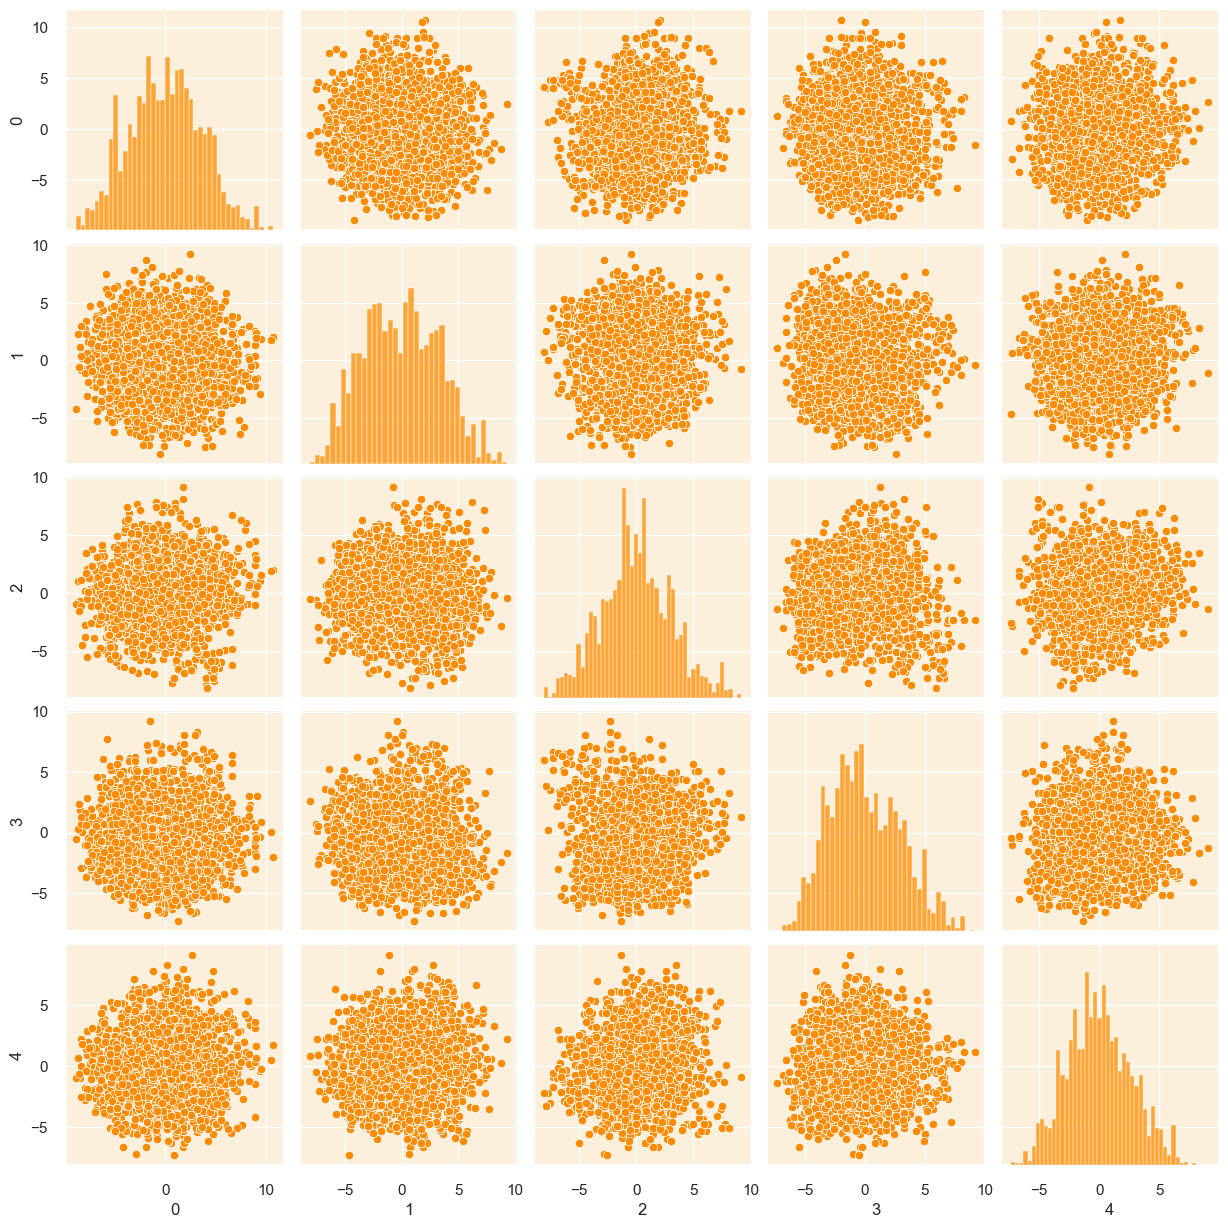

In [105]:
sns.pairplot(pca_data)

In [106]:
cos_sim_data = pd.DataFrame(cosine_similarity(X))

In [107]:
cos_sim_data

0         1         2         3         4         5         6     \
0     1.000000  0.402748  0.409845  0.345060  0.488421  0.346632  0.244234   
1     0.402748  1.000000  0.780599  0.302174  0.659942  0.663709  0.332487   
2     0.409845  0.780599  1.000000  0.368156  0.505862  0.414979  0.297621   
3     0.345060  0.302174  0.368156  1.000000  0.398761  0.272115  0.328871   
4     0.488421  0.659942  0.505862  0.398761  1.000000  0.813157  0.323373   
...        ...       ...       ...       ...       ...       ...       ...   
9995  0.443159  0.442979  0.511531  0.304989  0.566324  0.508518  0.308215   
9996  0.222911  0.254226  0.264323  0.295530  0.329172  0.443838  0.298945   
9997  0.409455  0.381483  0.404134  0.402949  0.574569  0.423551  0.138740   
9998  0.358532  0.477167  0.382474  0.398078  0.567920  0.603155  0.327006   
9999  0.314270  0.309389  0.287832  0.437955  0.286734  0.190809  0.215299   

          7         8         9     ...      9990      9991      9992  \
0     0.267533  0.206737  0.172457  ...  0.304660  0.262508  0.328410   
1     0.411858  0.404966  0.167479  ...  0.502336  0.381540  0.316507   
2     0.443487  0.321169  0.130175  ...  0.543439  0.447770  0.347939   
3     0.352677  0.444065  0.139237  ...  0.327653  0.423601  0.366789   
4     0.550919  0.381749  0.372533  ...  0.506507  0.318870  0.377714   
...        ...       ...       ...  ...       ...       ...       ...   
9995  0.376359  0.268688  0.284488  ...  0.480170  0.345538  0.374032   
9996  0.418334  0.315973  0.328613  ...  0.359317  0.276003  0.187859   
9997  0.450466  0.227595  0.189332  ...  0.424599  0.296791  0.444500   
9998  0.490563  0.434098  0.439439  ...  0.584317  0.440112  0.377302   
9999  0.407509  0.312026  0.195393  ...  0.205499  0.294175  0.479770   

          9993      9994      9995      9996      9997      9998      9999  
0     0.363551  0.436149  0.443159  0.222911  0.409455  0.358532  0.314270  
1     0.347249  0.673373  0.442979  0.254226  0.381483  0.477167  0.309389  
2     0.252326  0.562235  0.511531  0.264323  0.404134  0.382474  0.287832  
3     0.381630  0.311399  0.304989  0.295530  0.402949  0.398078  0.437955  
4     0.308415  0.755355  0.566324  0.329172  0.574569  0.567920  0.286734  
...        ...       ...       ...       ...       ...       ...       ...  
9995  0.243943  0.815155  1.000000  0.439305  0.496916  0.489644  0.272835  
9996  0.284007  0.432265  0.439305  1.000000  0.307945  0.464153  0.438408  
9997  0.263811  0.610425  0.496916  0.307945  1.000000  0.376133  0.356549  
9998  0.469302  0.566401  0.489644  0.464153  0.376133  1.000000  0.317700  
9999  0.248233  0.218240  0.272835  0.438408  0.356549  0.317700  1.000000  

[10000 rows x 10000 columns]

# SARIMA

In [108]:
df.shape

(794096, 15)

In [109]:
df.head(100)

Invoice StockCode                          Description  Quantity  \
0   489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1   489434    79323P                   PINK CHERRY LIGHTS        12   
2   489434    79323W                  WHITE CHERRY LIGHTS        12   
3   489434     22041          RECORD FRAME 7" SINGLE SIZE        48   
4   489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   
..     ...       ...                                  ...       ...   
95  489442     21955     UNION JACK GUNS & ROSES  DOORMAT         2   
96  489442     22111         SCOTTIE DOG HOT WATER BOTTLE         3   
97  489442     22296            HEART IVORY TRELLIS LARGE        12   
98  489442    84899E   YELLOW + BROWN BEAR FELT PURSE KIT        12   
99  489442     22271                 FELTCRAFT DOLL ROSIE         6   

           InvoiceDate  Price Customer ID         Country Transaction_Status  \
0  2009-12-01 07:45:00   6.95       13085  United Kingdom          Completed   
1  2009-12-01 07:45:00   6.75       13085  United Kingdom          Completed   
2  2009-12-01 07:45:00   6.75       13085  United Kingdom          Completed   
3  2009-12-01 07:45:00   2.10       13085  United Kingdom          Completed   
4  2009-12-01 07:45:00   1.25       13085  United Kingdom          Completed   
..                 ...    ...         ...             ...                ...   
95 2009-12-01 09:46:00   6.75       13635  United Kingdom          Completed   
96 2009-12-01 09:46:00   4.95       13635  United Kingdom          Completed   
97 2009-12-01 09:46:00   1.65       13635  United Kingdom          Completed   
98 2009-12-01 09:46:00   1.25       13635  United Kingdom          Completed   
99 2009-12-01 09:46:00   2.95       13635  United Kingdom          Completed   

    Revenue  InvoiceDay  Day_Of_Week  Hour  Month  Year  
0     83.40  2009-12-01            1     7     12  2009  
1     81.00  2009-12-01            1     7     12  2009  
2     81.00  2009-12-01            1     7     12  2009  
3    100.80  2009-12-01            1     7     12  2009  
4     30.00  2009-12-01            1     7     12  2009  
..      ...         ...          ...   ...    ...   ...  
95    13.50  2009-12-01            1     9     12  2009  
96    14.85  2009-12-01            1     9     12  2009  
97    19.80  2009-12-01            1     9     12  2009  
98    15.00  2009-12-01            1     9     12  2009  
99    17.70  2009-12-01            1     9     12  2009  

[100 rows x 15 columns]

In [110]:
Sales = df.groupby('InvoiceDay')['Revenue'].sum().reset_index()
Sales['InvoiceDay']= pd.to_datetime(Sales['InvoiceDay'])
Sales = Sales.set_index('InvoiceDay') 
Sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 604 entries, 2009-12-01 to 2011-12-09
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  604 non-null    float64
dtypes: float64(1)
memory usage: 9.4 KB


In [111]:
y = Sales['Revenue'].resample('MS').mean()
y

InvoiceDay
2009-12-01    31366.436190
2010-01-01    21936.673333
2010-02-01    20246.250833
2010-03-01    24313.445185
2010-04-01    25008.316522
2010-05-01    23156.203333
2010-06-01    23174.801923
2010-07-01    21710.868846
2010-08-01    22394.533846
2010-09-01    29930.176538
2010-10-01    37935.264615
2010-11-01    43118.482692
2010-12-01    27394.696000
2011-01-01    19642.930833
2011-02-01    18084.090417
2011-03-01    21227.335185
2011-04-01    20053.703333
2011-05-01    26011.969600
2011-06-01    24633.815769
2011-07-01    22310.181923
2011-08-01    23556.543462
2011-09-01    35450.720769
2011-10-01    36958.441923
2011-11-01    42796.273846
2011-12-01    42250.252500
Freq: MS, Name: Revenue, dtype: float64

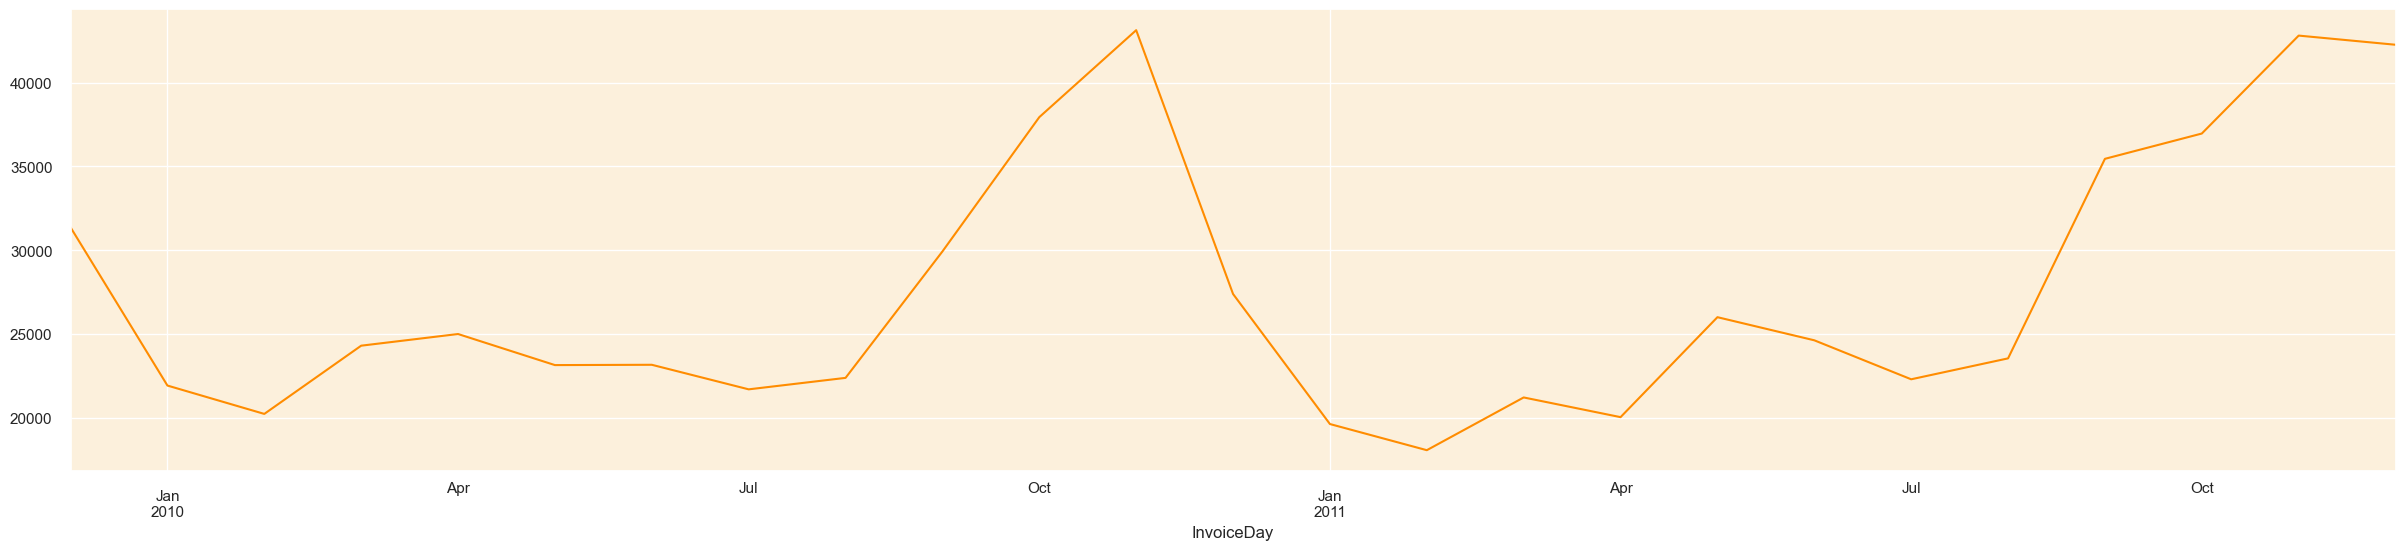

In [112]:
y.plot(figsize = (30, 6))
plt.show()

In [113]:
y.shape

(25,)

In [114]:
#pip install statsmodels


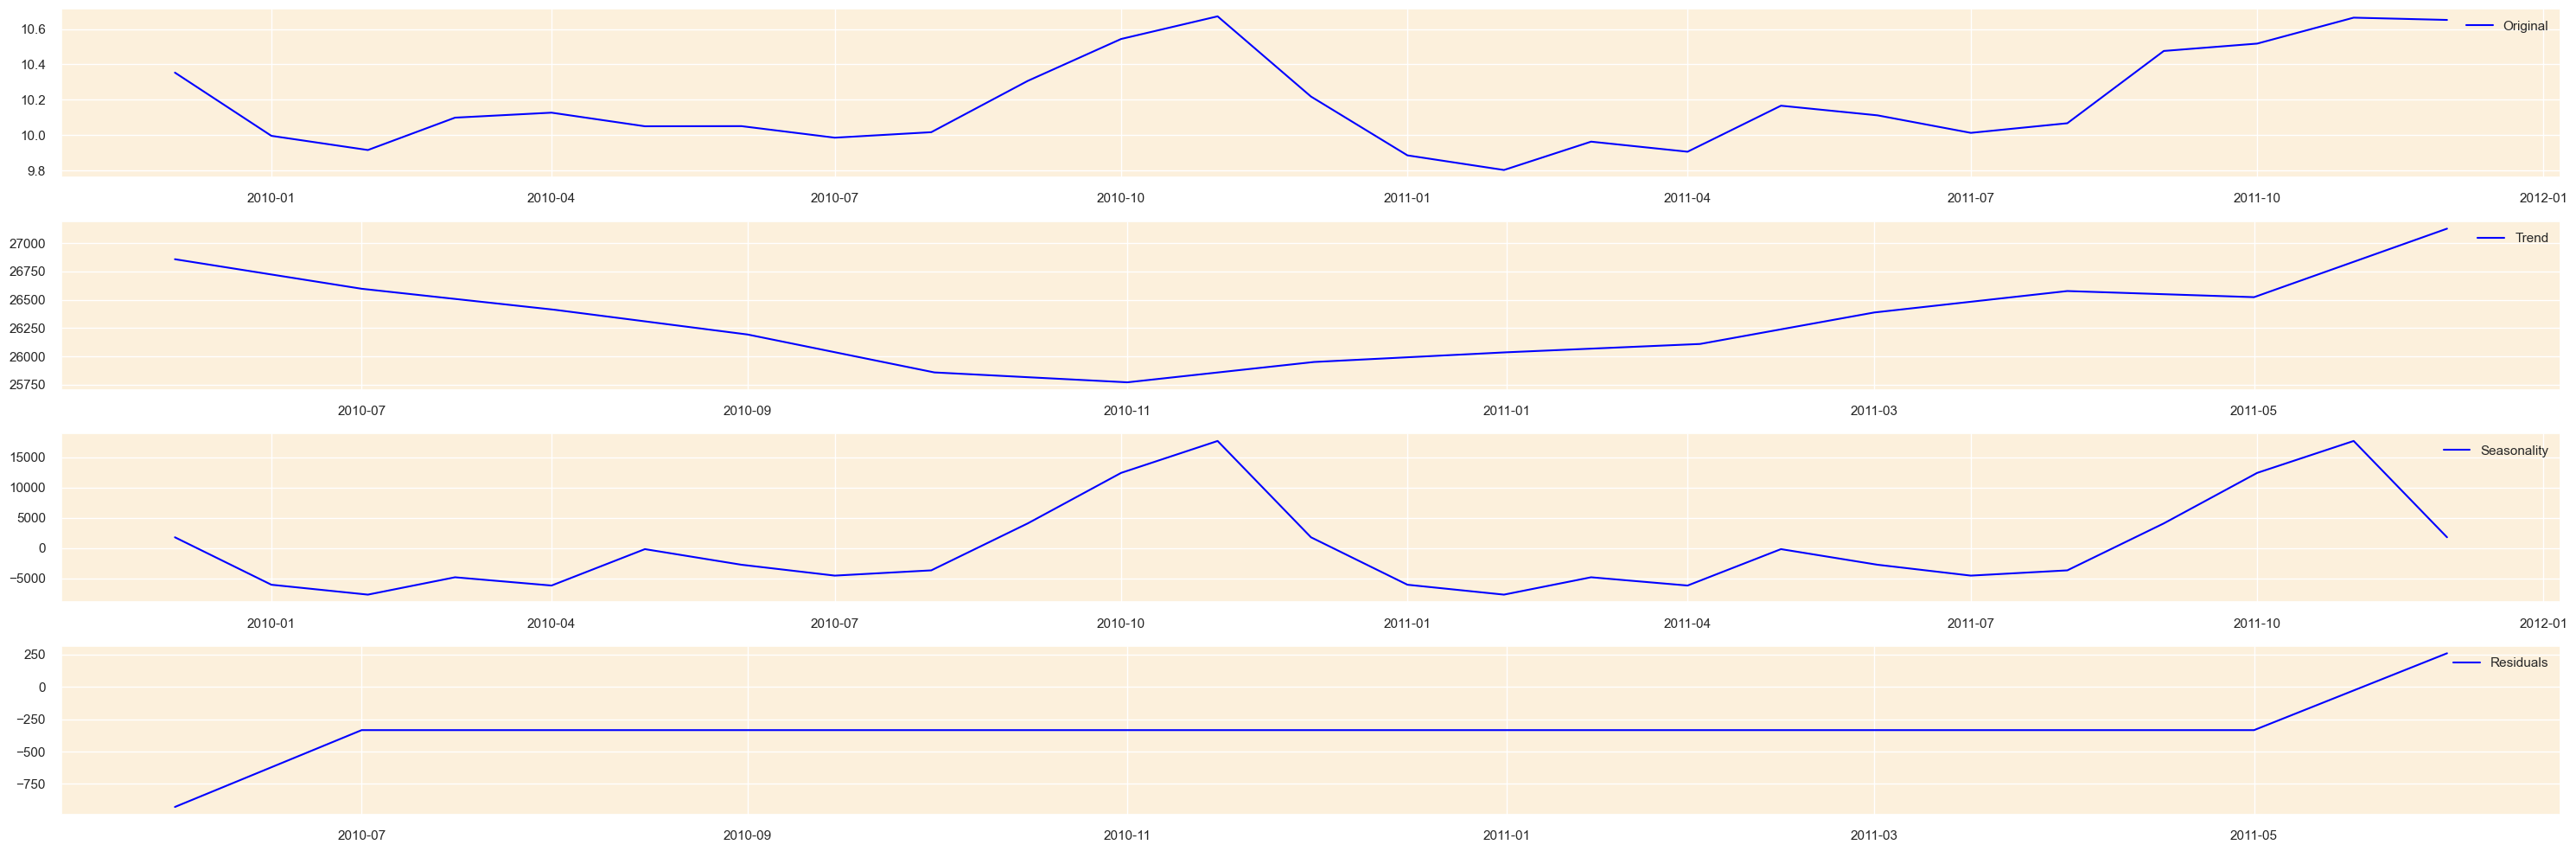

In [115]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 18,8

decomposition =  sm.tsa.seasonal_decompose(y)
#fig = decomposition.plot()
#plt.show()
trend = decomposition.trend
seasonal = decomposition.seasonal 
residual =  decomposition.resid

plt.figure(figsize = (30, 10))
plt.subplot(411)
plt.plot(np.log(y), label ='Original', color = 'blue')
plt.legend(loc ='best')
plt.subplot(412)
plt.plot(trend, label ='Trend', color = 'blue')
plt.legend(loc ='best')
plt.subplot(413)
plt.plot(seasonal, label ='Seasonality', color = 'blue')
plt.legend(loc ='best')
plt.subplot(414)
plt.plot(residual, label ='Residuals', color = 'blue')
plt.legend(loc ='best')
plt.tight_layout()
# seasonal.plot(figsize = (30, 6))
# residual.plot(figsize = (30, 6))


In [116]:
#pip install more-itertools
import itertools

In [117]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [118]:
ans = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=param_seasonal,enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            ans.append([param, param_seasonal, results.aic])
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

an_df = pd.DataFrame(ans, columns=['pdq','seasonal_pdq','aic'])
an_df .loc[an_df['aic'].idxmin()]

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:562.1622087231403
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:245.5942832914585
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:240.80447901578262
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:4.0
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:262.06294072307423


C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning:

invalid value encountered in divide

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:243.84783140384448
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:22.851108088295007
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:525.4987694285716
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:262.95420214032174
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:223.66439667248721


C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning:

invalid value encountered in divide

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:296.4607791777241
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:264.59329656114954


C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:25.11675668268521
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:8.0
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:464.15578896828697
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:218.16765926812022
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:223.58767182031528


C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:4.0
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:237.6058909764445
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:215.81151161866316
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:4.0
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:445.4241923287675


C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning:

invalid value encountered in divide

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarni

ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:201.57482029302977
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:205.50861943030853
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:6.0
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:239.07961759866436
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:202.60311244090423
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:6.0


C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning:

invalid value encountered in divide

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarni

ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:8.0
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:488.02003265777216
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:241.28126478691948
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:242.56947103780743
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:6.0
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:241.24059166255955


C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning:

invalid value encountered in divide

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:240.4100316392691
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:6.0
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:8.0
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:466.3861237056331
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:222.332588758869


C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning:

invalid value encountered in divide

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning:

invalid value encountered in divide

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All paramete

ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:225.5545739815134
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:8.0
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:242.26275215492512


C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:222.8876305497535
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:8.0
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:10.0
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:464.75648298501784
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:220.15548929817825
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:225.1327678474744


C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1234: RuntimeWarning:

invalid value encountered in divide

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:6.0
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:221.61869920343466
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:215.30984955961816
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:6.0


C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:8.0
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:447.3665826251076
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:204.30407840311625
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:207.41804074638384
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:8.0
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:224.1408115538991


C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:198.43022407479341
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:8.0
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:10.0


C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



pdq                 (0, 0, 0)
seasonal_pdq    (0, 1, 1, 12)
aic                       4.0
Name: 3, dtype: object

In [119]:
mod = sm.tsa.statespace.SARIMAX(y, order=(1, 1, 1), seasonal_order=(1, 0, 1, 12), enforce_stationarity=False, enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

C:\ProgramData\Anaconda3\envs\imblearn\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2371      0.570     -0.416      0.678      -1.355       0.881
ma.L1         -0.3850      0.349     -1.103      0.270      -1.069       0.299
ar.S.L12       1.5354      1.311      1.171      0.241      -1.034       4.105
ma.S.L12      -0.7856      1.643     -0.478      0.633      -4.006       2.435
sigma2      7.625e+06   7.06e-07   1.08e+13      0.000    7.62e+06    7.62e+06


In [120]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()
#results

ValueError: Length of endogenous variable must be larger the the number of lags used in the model and the number of observations burned in the log-likelihood calculation.

<Figure size 1600x800 with 0 Axes>

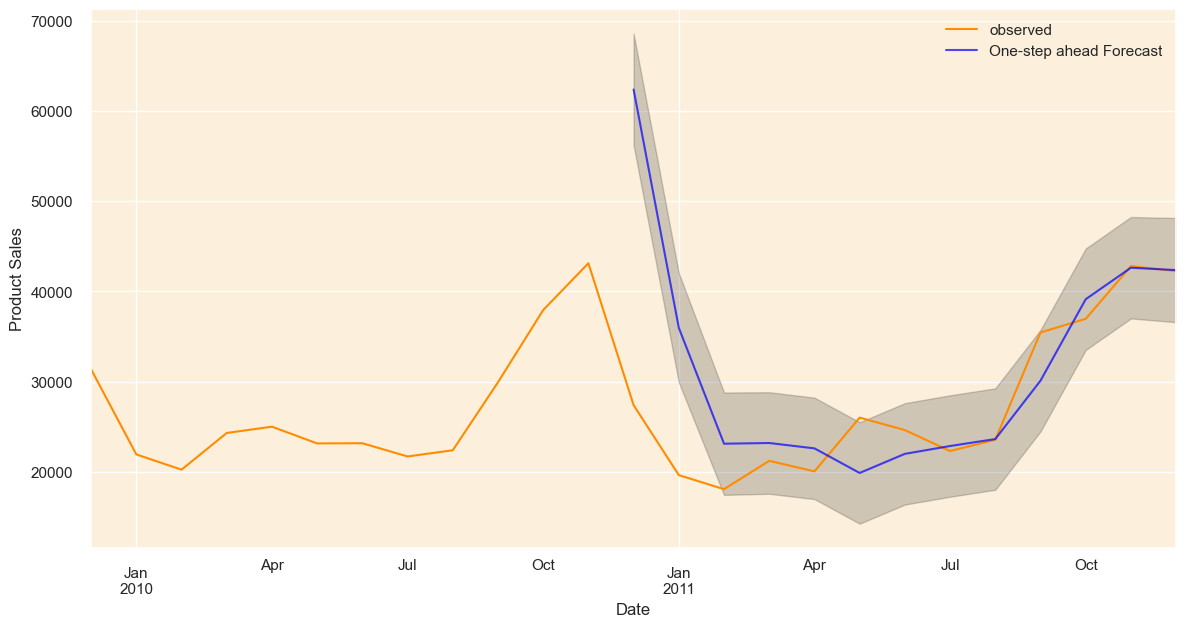

In [121]:
pred = results.get_prediction(start=pd.to_datetime('2010-12-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2009':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', color = 'blue',alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Product Sales')
plt.legend()
plt.show()


In [122]:
y_forecasted = pred.predicted_mean
y_truth = y['2010-12-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))


The Mean Squared Error of our forecasts is 123382296.54
The Root Mean Squared Error of our forecasts is 11107.76


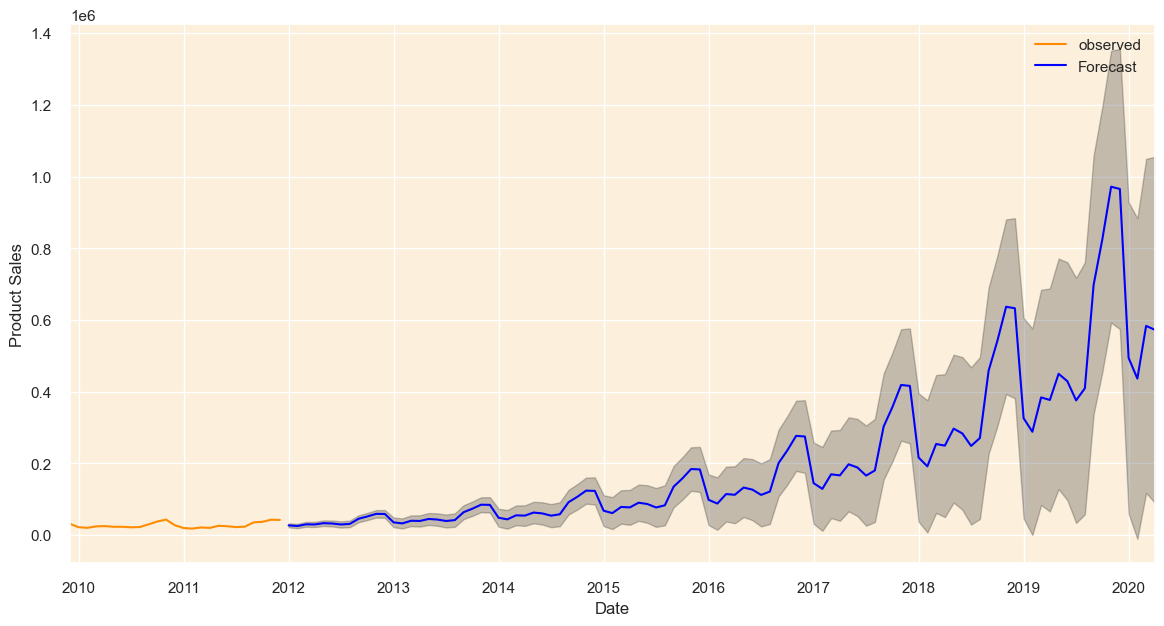

In [123]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast' , color = 'blue')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Product Sales')
plt.legend()
plt.show()


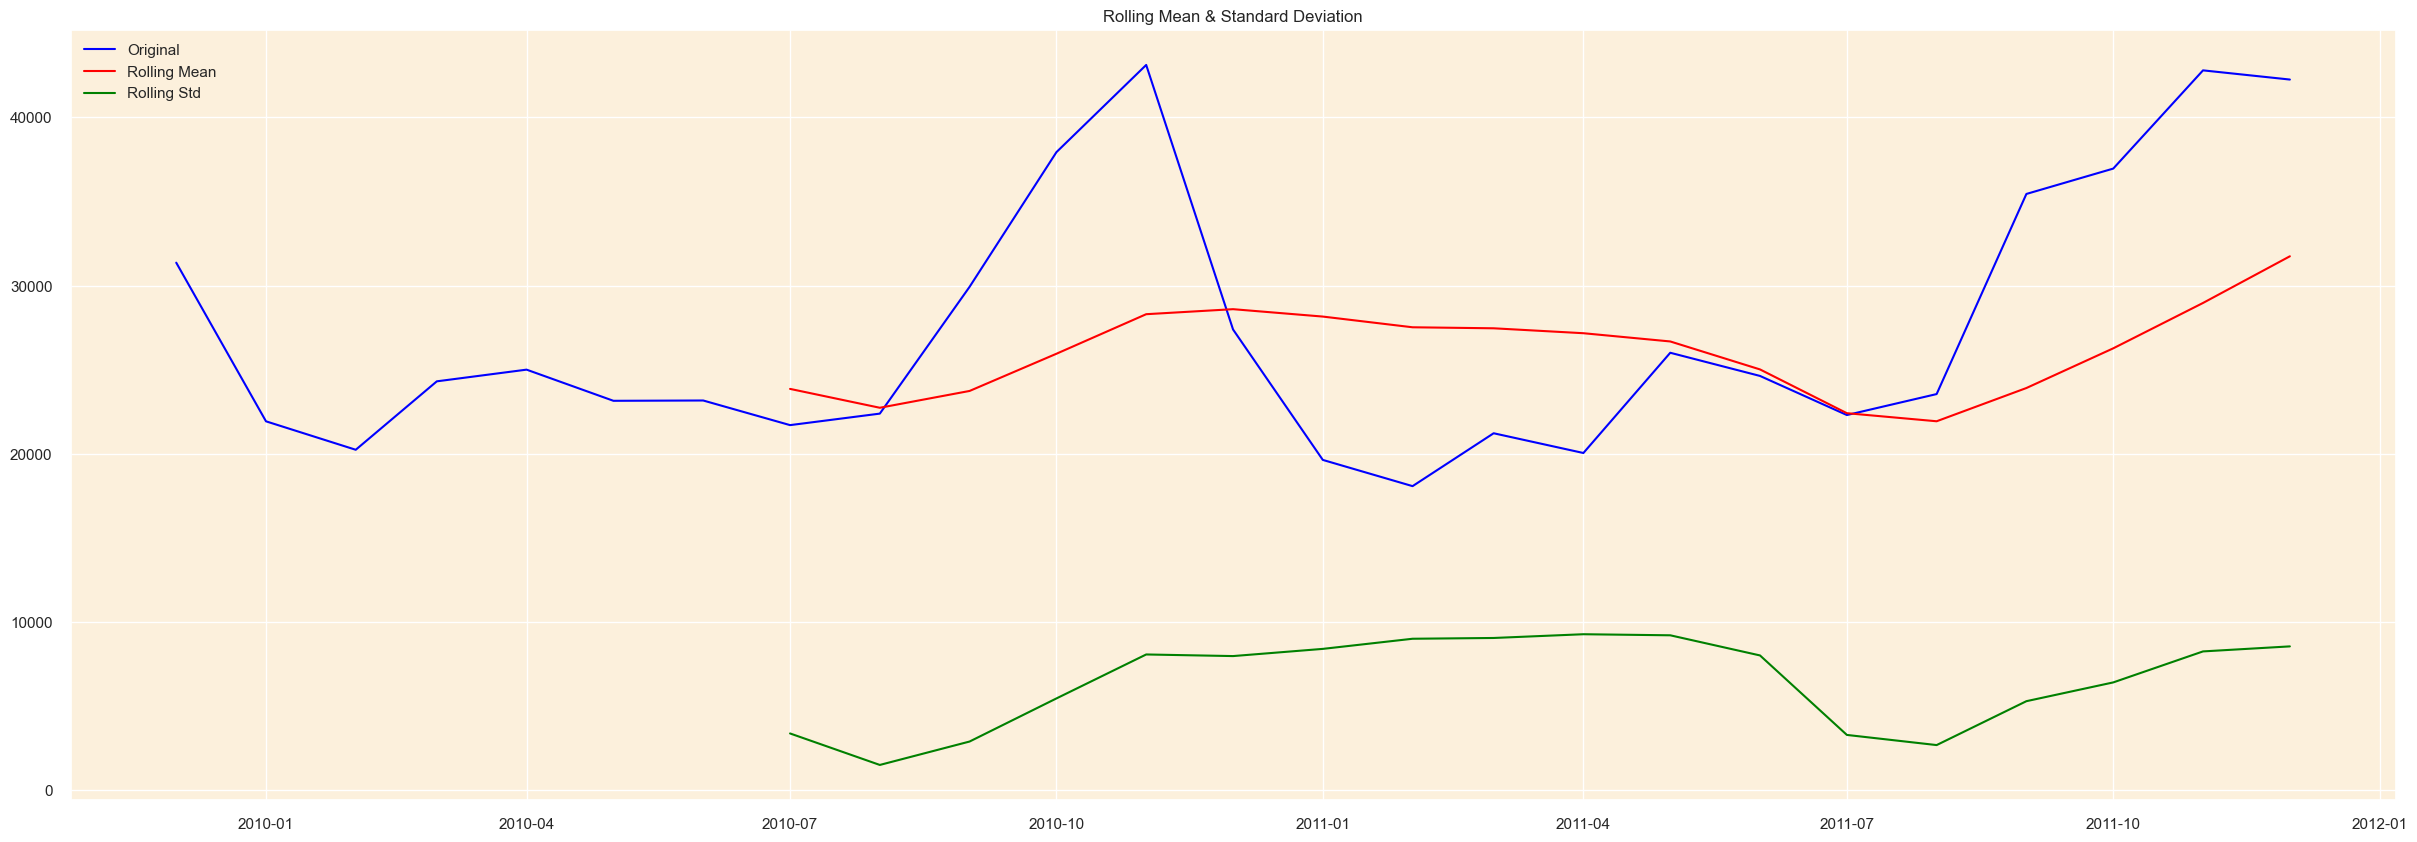

Results of Dickey-Fuller Test:
Test Statistics               -1.662623
p-value                        0.450466
#Lags Used                     9.000000
Number of Observation Used    15.000000
Critical Value(1%)            -3.964443
Critical Value(5%)            -3.084908
Critical Value(10%)           -2.681814
dtype: float64


In [124]:
from statsmodels.tsa.stattools import adfuller

rolemean = y.rolling(window = 8, center = False).mean()
rolestd = y.rolling(window = 8, center = False).std()

dftest = adfuller(y)

fig = plt.figure(figsize = (30, 10))
orig = plt.plot(y, color = 'blue', label = 'Original')
mean = plt.plot(rolemean, color = 'red', label = 'Rolling Mean')
std = plt.plot(rolestd, color = 'green', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block = False)

print('Results of Dickey-Fuller Test:')

dfoutput = pd.Series(dftest[0:4], index = ['Test Statistics','p-value','#Lags Used','Number of Observation Used'] )
for key,value in dftest[4].items():
    dfoutput['Critical Value(%s)'%key] = value
print(dfoutput)

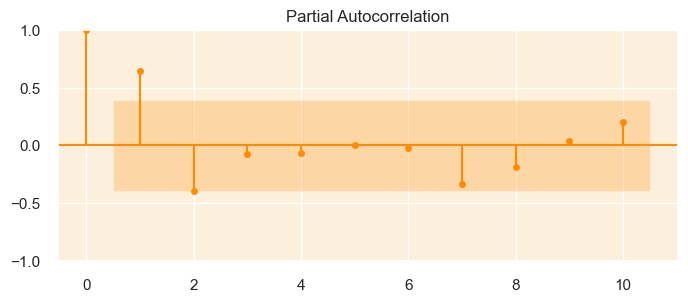

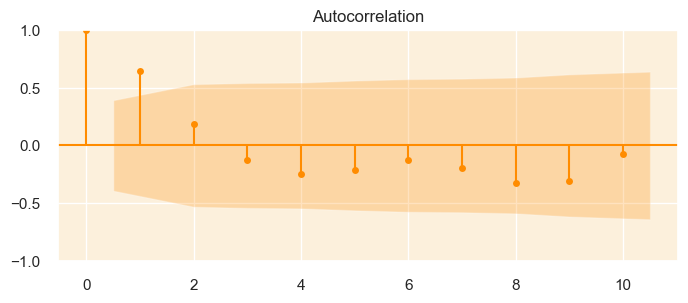

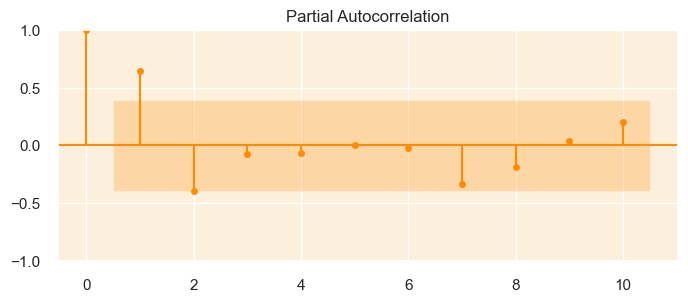

In [125]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax= plt.subplots(figsize = (8,3))
plot_acf(y,ax=ax, lags = 10)

fig, ax= plt.subplots(figsize = (8,3))
plot_pacf(y,ax=ax, lags = 10)